# Identification of novel antimicrobial resistance genes usign machine learning, homology modeling and molecular docking

## Part 1/3

Jupyter Notebook by: Janak Sunuwar

Following is a machine learning framework that uses complete gene set of several bacterial strains known to be susceptible or resistant to specific antibiotics and associated phenothypic information to prioritize genes and subsequent molecular docking studies to indicate stable interactions between these proteins and antimicrobials.

This framework highlights to uncover novel genes that have yet not been implicated in resistance to any antimicrobials and demonstrates potential interaction with respective antibiotics following the homology modeling and molecular docking.

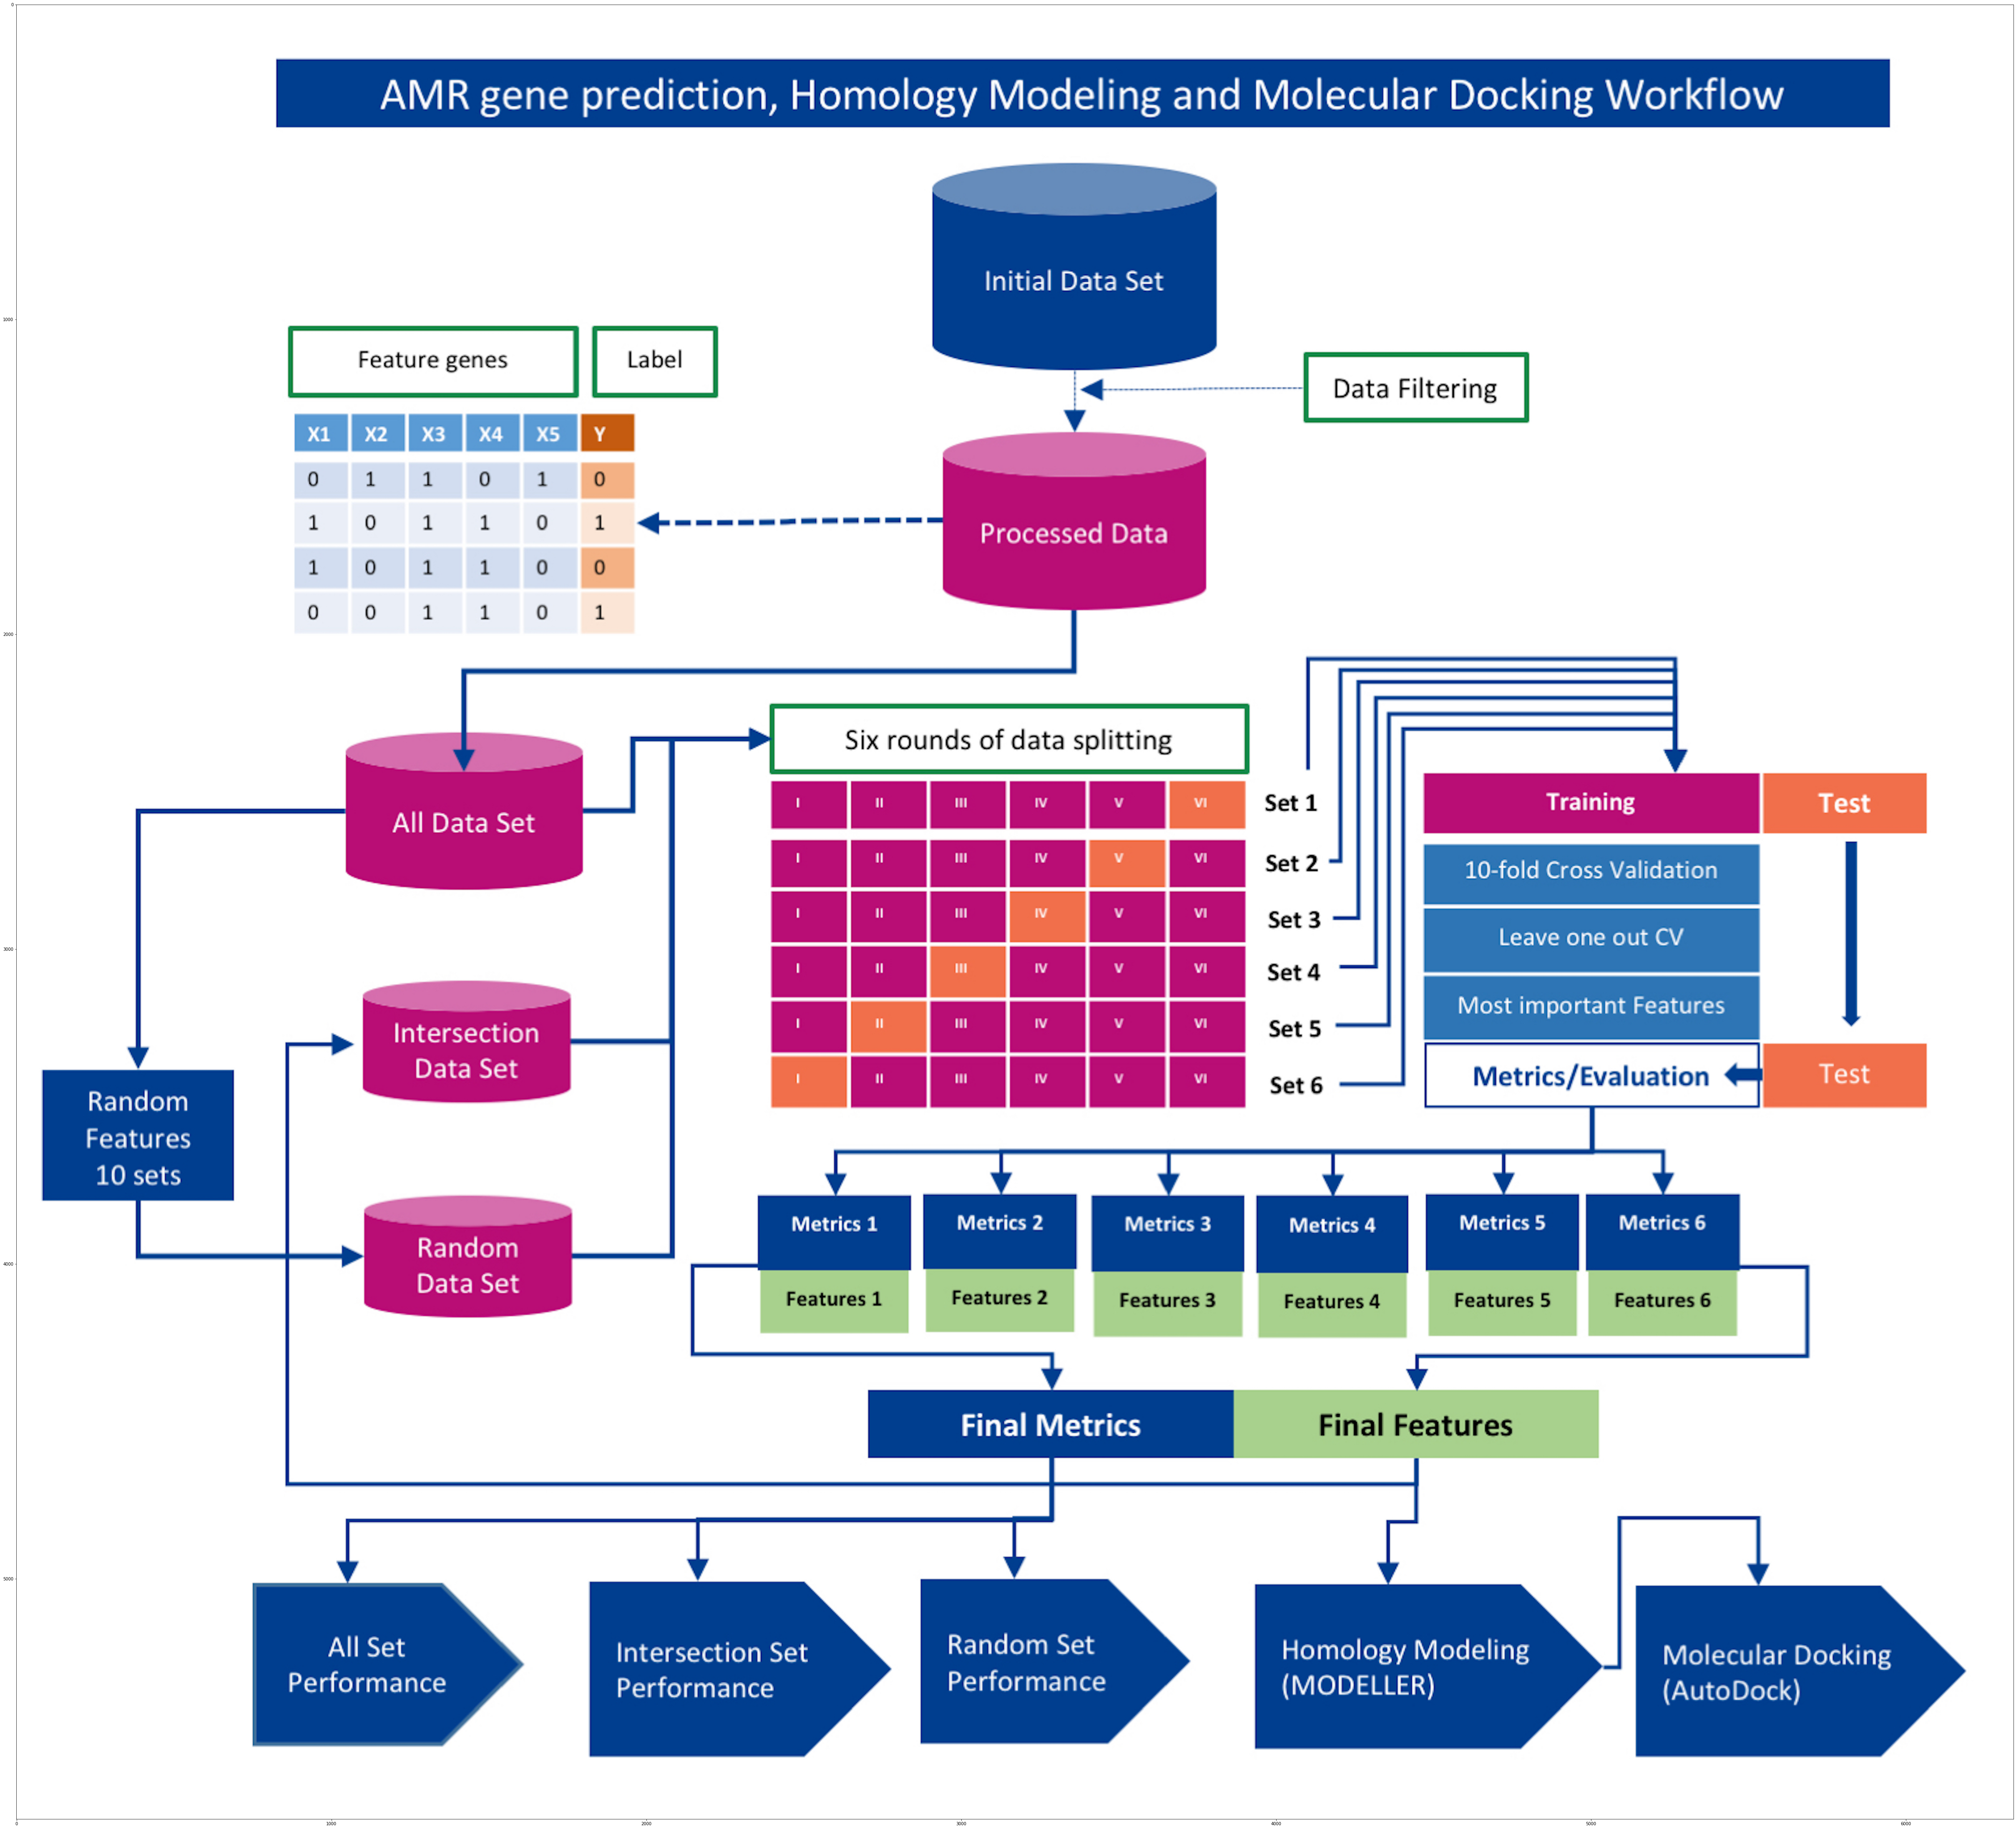

In [1]:
import cv2
from matplotlib import pyplot as plt
import matplotlib 
%matplotlib inline
#Acquire default dots per inch value of matplotlib
dpi = matplotlib.rcParams['figure.dpi']
#read the file
img = cv2.imread(r'Fig1_git.png')
#Change cv2 color code to RGB
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#figure size
height, width, depth = img.shape
figsize = width/float(dpi), height/float(dpi)
#show figure
plt.figure(figsize=figsize)
plt.imshow(img)
plt.show()

In [2]:
#All set, Intersection set and Random set performance with comparision plot

def ML_Run():
    import warnings
    warnings.filterwarnings('ignore')
    import pandas as pd
    import numpy as np
    np.random.seed(1)
    import sklearn
    import sklearn.model_selection
    import sklearn.metrics
    import sklearn.ensemble
    import matplotlib.pyplot as plt
    from matplotlib import rc
    %matplotlib inline
    global data
    
    #Split data into features and labels
    X = data.iloc[:,1:-1] 
    Y = data.iloc[:,-1] # last column label

    #Label size and matrix size
    All_Set_Data_size = data.groupby(antb).size()
    All_Set_Matrix_size = data.shape

    #Import classifiers
    from sklearn import model_selection
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.linear_model import LogisticRegression
    from sklearn.naive_bayes import GaussianNB
    from sklearn.naive_bayes import MultinomialNB
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.svm import SVC
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
    from sklearn.ensemble import ExtraTreesClassifier
    from sklearn.ensemble import AdaBoostClassifier
    from sklearn.ensemble import GradientBoostingClassifier
    from sklearn.ensemble import BaggingClassifier
    from sklearn.metrics import roc_curve, roc_auc_score
    from sklearn.metrics import precision_recall_curve
    from sklearn.metrics import f1_score
    from sklearn.metrics import auc
    from sklearn.metrics import precision_score, recall_score
    import pickle
    from sklearn.model_selection import StratifiedKFold
    from sklearn.model_selection import LeaveOneOut 
    from sklearn.model_selection import cross_val_score

    #Create dataframes for outputs
    Training_Performance = pd.DataFrame(columns=[])
    Test_Performance = pd.DataFrame(columns=[])
    Tf_CV = pd.DataFrame(columns=[])
    Area_Under_ROC = pd.DataFrame(columns=[])
    Area_Under_Precision_Recall = pd.DataFrame(columns=[])
    Model_Predict = pd.DataFrame(columns=[])

    #Split data into 6 equal parts
    skf = StratifiedKFold(n_splits=validation_no, random_state=42)
    i = 0
    for train_index, test_index in skf.split(X, Y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]

        #Build and evaluate models
        models = []
        models.append(('LogR', LogisticRegression(max_iter=10000)))
        models.append(('gNB', GaussianNB()))
        models.append(('SVM', SVC(kernel = 'rbf', probability=True)))
        models.append(('DT', DecisionTreeClassifier(criterion = 'entropy', random_state=1)))
        models.append(('RF', RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state=0)))
        models.append(('KNN', KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)))
        models.append(('LDA', LinearDiscriminantAnalysis()))
        models.append(('mNB', MultinomialNB()))
        models.append(('ABC', AdaBoostClassifier()))
        models.append(('GBC', GradientBoostingClassifier()))
        models.append(('ETC', ExtraTreesClassifier()))
        models.append(('BC', BaggingClassifier()))

        #Training performances
        myDF1 = pd.DataFrame(columns=[])
        for name, model in models:    
            model = model.fit(X_train, Y_train)
            Y_train_pred = model.predict(X_train)
            Tr_precision = precision_score(Y_train, Y_train_pred).round(3)
            Tr_recall = recall_score(Y_train, Y_train_pred).round(3)
            Tr_f1 = f1_score (Y_train, Y_train_pred).round(3)
            myDF1 = myDF1.append({'classifier': name, f'tr_precision{i+1}': Tr_precision, f'tr_recall{i+1}': Tr_recall, f'tr_f1 {i+1}':Tr_f1}, ignore_index = True)
        Training_Performance = pd.concat([Training_Performance, myDF1], axis = 1)

        #Ten-fold cross validation
        myDF3 = pd.DataFrame(columns=[])
        for name, model in models:
            kfold = model_selection.KFold(n_splits=10, random_state=42)
            results = model_selection.cross_val_score(model, X_train, Y_train, cv=kfold)
            mean= results.mean().round(3)
            std = results.std()
            myDF3 = myDF3.append({'classifier': name, f'ten_f_CV{i+1}':mean}, ignore_index = True)
        Tf_CV = pd.concat([Tf_CV, myDF3], axis = 1)
        
        #Test performances
        myDF2 = pd.DataFrame(columns=[])
        for name, model in models:  
            model = model.fit(X_train, Y_train)
            Y_test_pred = model.predict(X_test)
            report = sklearn.metrics.classification_report(Y_test, Y_test_pred)
            Te_precision = precision_score(Y_test, Y_test_pred).round(3)
            Te_recall = recall_score(Y_test, Y_test_pred).round(3)
            Te_f1 = f1_score (Y_test, Y_test_pred).round(3)
            myDF2 = myDF2.append({'classifier': name, f'te_precision{i+1}': Te_precision, f'te_recall{i+1}': Te_recall, f'te_f1 {i+1}':Te_f1}, ignore_index = True)
        Test_Performance = pd.concat([Test_Performance, myDF2], axis = 1)

        #AU_ROC
        myDF4 = pd.DataFrame(columns=[])
        for name, model in models:
            model = model.fit(X_train, Y_train)
            y_pred_proba = model.predict_proba(X_test)[::,1]
            fpr, tpr, _ = roc_curve(Y_test,  y_pred_proba, pos_label = None)
            a_u_c = roc_auc_score(Y_test, y_pred_proba).round(3)
            myDF4 = myDF4.append({'a classifier': name, f'au ROC {i+1}': a_u_c}, ignore_index = True)
        Area_Under_ROC = pd.concat([Area_Under_ROC, myDF4], axis = 1)

        #AUPR
        myDF5 = pd.DataFrame(columns=[])
        for name, model in models:
            #predict probabilities
            y_pred_proba = model.predict_proba(X_test)
            # keep probabilities for the positive outcome only
            y_pred_proba = y_pred_proba[:, 1]
            #predict class vlaues
            y_pred = model.predict(X_test)
            # calculate precision-recall curve
            precision, recall, _ = precision_recall_curve(Y_test, y_pred_proba)
            # calculate au precision-recall curve
            area = auc(recall, precision).round(3)
            # calculate f1 score
            f1 = f1_score(Y_test, y_pred).round(3)
            myDF5 = myDF5.append({'a classifier': name, f'au PR {i+1}': area}, ignore_index = True)
        Area_Under_Precision_Recall = pd.concat([Area_Under_Precision_Recall, myDF5], axis = 1)
        i += 1

    #Model names
    Models = Tf_CV.iloc[:, 0] 
    
    #Calculating the mean of all folds
    #training f1 average
    tr_f1_avg = Training_Performance[Training_Performance.columns[1::4]].mean(axis=1).round(3).rename('tr_f1_avg_as', inplace=True)
    tr_f1_stdev = Training_Performance[Training_Performance.columns[1::4]].std(axis=1).round(3).rename('tr_f1_stdev_as', inplace=True)

    #Training precision average
    tr_precision_avg = Training_Performance[Training_Performance.columns[2::4]].mean(axis=1).round(3).rename('tr_precision_avg_as', inplace=True)
    tr_precision_stdev = Training_Performance[Training_Performance.columns[2::4]].std(axis=1).round(3).rename('tr_precision_stdev_as', inplace=True)
    
    #Training recall average
    tr_recall_avg = Training_Performance[Training_Performance.columns[3::4]].mean(axis=1).round(3).rename('tr_recall_avg_as', inplace=True)
    tr_recall_stdev = Training_Performance[Training_Performance.columns[3::4]].std(axis=1).round(3).rename('tr_recall_stdev_as', inplace=True)
 
    #Test f1 average
    te_f1_avg = Test_Performance[Test_Performance.columns[1::4]].mean(axis=1).round(3).rename('te_f1_avg_as', inplace=True)
    te_f1_stdev = Test_Performance[Test_Performance.columns[1::4]].std(axis=1).round(3).rename('te_f1_stdev_as', inplace=True)
    
    #Test precision average
    te_precision_avg = Test_Performance[Test_Performance.columns[2::4]].mean(axis=1).round(3).rename('te_precision_avg_as', inplace=True)
    te_precision_stdev = Test_Performance[Test_Performance.columns[2::4]].std(axis=1).round(3).rename('te_precision_stdev_as', inplace=True)

    #Test recall average
    te_recall_avg = Test_Performance[Test_Performance.columns[3::4]].mean(axis=1).round(3).rename('te_recall_avg_as', inplace=True)
    te_recall_stdev = Test_Performance[Test_Performance.columns[3::4]].std(axis=1).round(3).rename('te_recall_stdev_as', inplace=True)
    
    #Tf_CV average
    Tf_CV_Avg = Tf_CV[Tf_CV.columns[1::2]].mean(axis=1).round(3).rename('Tf_CV_Avg_as', inplace=True)
    Tf_CV_stdev = Tf_CV[Tf_CV.columns[1::2]].std(axis=1).round(3).rename('Tf_CV_stdev_as', inplace=True)
    
    #Area_Under_ROC average
    au_ROC_avg = Area_Under_ROC[Area_Under_ROC.columns[1::2]].mean(axis=1).round(3).rename('au_ROC_avg_as', inplace=True)
    au_ROC_stdev = Area_Under_ROC[Area_Under_ROC.columns[1::2]].std(axis=1).round(3).rename('au_ROC_stdev_as', inplace=True)
    
    #Area_Under_Precision_Recall average
    au_PR_avg= Area_Under_Precision_Recall[Area_Under_Precision_Recall.columns[1::2]].mean(axis=1).round(3).rename('au_PR_avg_as', inplace=True)
    au_PR_stdev= Area_Under_Precision_Recall[Area_Under_Precision_Recall.columns[1::2]].std(axis=1).round(3).rename('au_PR_stdev_as', inplace=True)

    #Accumulating all dataframes
    frames2 = [Models, 
               tr_precision_avg, tr_precision_stdev, tr_recall_avg, tr_recall_stdev, tr_f1_avg, tr_f1_stdev, 
               te_precision_avg, te_precision_stdev, te_recall_avg, te_recall_stdev, te_f1_avg, te_f1_stdev,
               Tf_CV_Avg, Tf_CV_stdev, au_ROC_avg, au_ROC_stdev, au_PR_avg, au_PR_stdev]
    
    #Result all set
    Final_All_set_Results= pd.concat(frames2, axis=1)
    
    #Leave one out cross validation
    #List for output
    Loo = []
    
    #Leave one out validation
    cv = LeaveOneOut()
    from numpy import mean
    from numpy import std
    #Evaluate each model for Loo CV
    for name, model in models:
        # fit model
        scores = cross_val_score(model, X, Y, cv = cv, scoring='accuracy', n_jobs=-1)
        Loo_avg = mean(scores).round(3)
        Loo_stdev = std(scores).round(3)
        Loo.append({'Loo_CV_as': Loo_avg, 'Loo_stdev_as': Loo_stdev})
    
    Loo_CV = pd.DataFrame(Loo)
    Final_All_set_Results = pd.concat([Final_All_set_Results, Loo_CV], axis=1)
    
    print(f'All Set Results {antb} {bacteria}')
    display(Final_All_set_Results)
    
    #Result out
    with open (file_all_out, 'a+') as rf:
        rf.write(f'\n{bacteria} {antb} All set Results\n')
        rf.write(f'\n{All_Set_Data_size}\n')
        rf.write(f'\nmatrix_size: {All_Set_Matrix_size}\n\n')
    
        Final_All_set_Results.to_csv(rf)
    
    #Export results separately
    Final_All_set_Results.to_csv(f'{bacteria}_{antb}_All_Set_Performance_{validation_no}-fold_CV.csv', encoding='utf-8')
    
    #Selecting important features in each fold from tree based-classifiers
    clfk = ExtraTreesClassifier(random_state=1)
    
    #Dataframes for output
    feat_Df = pd.DataFrame(columns=[])
    scores = []
    test_scores = []
    check_feat = []
    Output = pd.DataFrame()
    
    #Split the data
    skf = StratifiedKFold(n_splits=validation_no, random_state=42)
    j = 0
    
    for train_index, test_index in skf.split(X, Y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]
    
        #Fit the model
        modelk = clfk.fit(X_train,Y_train)
        predictions = clfk.predict(X_test)
        scores.append(clfk.score(X_test, Y_test))
        feat = clfk.feature_importances_
    
        #Select the column header from first to the second last
        colhead = list(np.array([data.columns[1:-1]]).T)
    
        #Zip two columns into a dataframe
        list_of_tuplesk= list(zip(colhead, feat))
    
        #Create features dataframe
        feature_importancek = pd.DataFrame(list_of_tuplesk, columns = [f'Feature fold{j}', f'Importance fold{j}'])
    
        #Sort the dataframe, descending
        feature_importance_sortedk = feature_importancek.sort_values(by=f'Importance fold{j}', ascending=False)
    
        #Remove the square brackets from the dataframe
        feature_importance_sortedk [f'Feature fold{j}'] = feature_importance_sortedk[f'Feature fold{j}'].str.get(0)
        feature_importance_sortedk = feature_importance_sortedk.round(3)
    
        #Sort the features
        feat_sort_df = pd.DataFrame(feature_importance_sortedk)
        feat_sort_df.reset_index(drop=True, inplace=True)
        feat_Df.reset_index(drop=True, inplace=True)
        feat_Df = pd.concat([feat_Df, feat_sort_df], axis= 1)
        j += 1
    
    #Select the top genes out from range
    top_genes_range = 8000
    
    #Make dataframe of selected top dataframes
    Top_consistent = feat_Df.iloc[0:top_genes_range, :]
    
    #Separate each column to separate dataframe and find common in all
    cdf1 = Top_consistent[['Feature fold0']].rename(columns={"Feature fold0": "Feature"})
    cdf2 = Top_consistent[['Feature fold1']].rename(columns={"Feature fold1": "Feature"})
    cdf3 = Top_consistent[['Feature fold2']].rename(columns={"Feature fold2": "Feature"})
    cdf4 = Top_consistent[['Feature fold3']].rename(columns={"Feature fold3": "Feature"})
    cdf5 = Top_consistent[['Feature fold4']].rename(columns={"Feature fold4": "Feature"})
    cdf6 = Top_consistent[['Feature fold5']].rename(columns={"Feature fold5": "Feature"})
    
    #export separate raw consistent genes without merge
    feat_Df.to_csv(f'{bacteria}_{antb}_Raw_Consistent_Genes_Per_{validation_no}-fold_CV.csv', encoding='utf-8')
    
    #Merging common in all folds
    merge12 = pd.merge(cdf1, cdf2, how='inner', on=['Feature'])
    merge123 = pd.merge(merge12, cdf3, how='inner', on=['Feature'])
    merge1234 = pd.merge(merge123, cdf4, how='inner', on=['Feature'])
    merge12345 = pd.merge(merge1234, cdf5, how='inner', on=['Feature'])
    Consistent_Genes_per_fold = pd.merge(merge12345, cdf6, how='inner', on=['Feature'])
    
    Final_Consistent_Genes_per_fold = Consistent_Genes_per_fold.iloc[:100, :]
    
    #Create a result file
    with open (file_all_out, 'a+') as rf:
        rf.write(f'\n{bacteria} {antb} Consistent Genes per {validation_no} fold validation All Set\n')
        Final_Consistent_Genes_per_fold.to_csv(rf)
    
    #Export consistent genes as separate file
    Final_Consistent_Genes_per_fold.to_csv(f'{bacteria}_{antb}_Consistent_Genes_Per_{validation_no}-fold_CV.csv', encoding='utf-8')
    
    #INTERSECTION SET RUN
    #Read gene_ast matrix
    open_gene_ast = pd.read_csv(file_name)
    
    #Open consistent genes based per validation
    open_consistent_genes = pd.read_csv(f'{bacteria}_{antb}_Consistent_Genes_Per_{validation_no}-fold_CV.csv')
    
    #Make separate dataframe with just consistent genes
    target_genesTT = open_consistent_genes[['Feature']].rename(columns={'Feature': 'Consistent genes'})
    
    #No of top consistent genes
    num = 100
    target_genesTT = target_genesTT.iloc[:num, :]
    
    #Sort the consistent genes
    target_genesTT = target_genesTT.sort_values('Consistent genes')
    
    #Adding antibiotic lable at the end
    target_genes_good = target_genesTT.append({'Consistent genes': f'{antb}'}, ignore_index=True)
    
    #Converting consistent genes to a list
    column_list = target_genes_good['Consistent genes'].tolist()
    
    #Adding phenotype lable at the end
    target_genes_good1 = target_genesTT.append({'Consistent genes': 'phenotype'}, ignore_index=True)
    
    #Converting consistent genes with phenotype to a list
    column_list1 = target_genes_good1['Consistent genes'].tolist()
    
    #Make data consisting only with consistent genes 
    data_I = open_gene_ast[column_list]
    
    #Label size and matrix size
    Intersection_Data_size = data_I.groupby(antb).size()
    Intersection_Matrix_size = data_I.shape
    
    #Split the data to features and labels
    X = data_I.iloc[:, 0:-1]
    Y = data_I.iloc[:,-1]
    
    #Create dataframes for outputs
    Training_Performance = pd.DataFrame(columns=[])
    Test_Performance = pd.DataFrame(columns=[])
    Tf_CV = pd.DataFrame(columns=[])
    Area_Under_ROC = pd.DataFrame(columns=[])
    Area_Under_Precision_Recall = pd.DataFrame(columns=[])
    Model_Predict = pd.DataFrame(columns=[])
    
    #Split data into 6 equal parts
    skf = StratifiedKFold(n_splits=validation_no, random_state=42)
    i = 0
    for train_index, test_index in skf.split(X, Y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]
    
        #Build and evaluate models
        models = []
        models.append(('LogR', LogisticRegression(max_iter=10000)))
        models.append(('gNB', GaussianNB()))
        models.append(('SVM', SVC(kernel = 'rbf', probability=True)))
        models.append(('DT', DecisionTreeClassifier(criterion = 'entropy', random_state=1)))
        models.append(('RF', RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state=0)))
        models.append(('KNN', KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)))
        models.append(('LDA', LinearDiscriminantAnalysis()))
        models.append(('mNB', MultinomialNB()))
        models.append(('ABC', AdaBoostClassifier()))
        models.append(('GBC', GradientBoostingClassifier()))
        models.append(('ETC', ExtraTreesClassifier()))
        models.append(('BC', BaggingClassifier()))
    
        #Training performances
        myDF1 = pd.DataFrame(columns=[])
        for name, model in models:    
            model = model.fit(X_train, Y_train)
            Y_train_pred = model.predict(X_train)
            Tr_precision = precision_score(Y_train, Y_train_pred).round(3)
            Tr_recall = recall_score(Y_train, Y_train_pred).round(3)
            Tr_f1 = f1_score (Y_train, Y_train_pred).round(3)
            myDF1 = myDF1.append({'classifier': name, f'tr_precision{i+1}': Tr_precision, f'tr_recall{i+1}': Tr_recall, f'tr_f1 {i+1}':Tr_f1}, ignore_index = True)
        Training_Performance = pd.concat([Training_Performance, myDF1], axis = 1)
    
        #Test performances
        myDF2 = pd.DataFrame(columns=[])
        for name, model in models:  
            model = model.fit(X_train, Y_train)
            Y_test_pred = model.predict(X_test)
            report = sklearn.metrics.classification_report(Y_test, Y_test_pred)
            Te_precision = precision_score(Y_test, Y_test_pred).round(3)
            Te_recall = recall_score(Y_test, Y_test_pred).round(3)
            Te_f1 = f1_score (Y_test, Y_test_pred).round(3)
            myDF2 = myDF2.append({'classifier': name, f'te_precision{i+1}': Te_precision, f'te_recall{i+1}': Te_recall, f'te_f1 {i+1}':Te_f1}, ignore_index = True)
        Test_Performance = pd.concat([Test_Performance, myDF2], axis = 1)
    
        #Ten-fold cross validation
        myDF3 = pd.DataFrame(columns=[])
        for name, model in models:
            kfold = model_selection.KFold(n_splits=10, random_state=42)
            results = model_selection.cross_val_score(model, X_train, Y_train, cv=kfold)
            mean = results.mean().round(3)
            std = results.std()
            myDF3 = myDF3.append({'classifier': name, f'ten_f_CV{i+1}':mean}, ignore_index = True)
        Tf_CV = pd.concat([Tf_CV, myDF3], axis = 1)
    
        #AU_ROC
        myDF4 = pd.DataFrame(columns=[])
        for name, model in models:
            model = model.fit(X_train, Y_train)
            y_pred_proba = model.predict_proba(X_test)[::,1]
            fpr, tpr, _ = roc_curve(Y_test,  y_pred_proba, pos_label = None)
            a_u_c = roc_auc_score(Y_test, y_pred_proba).round(3)
            myDF4 = myDF4.append({'a classifier': name, f'au ROC {i+1}': a_u_c}, ignore_index = True)
        Area_Under_ROC = pd.concat([Area_Under_ROC, myDF4], axis = 1)
    
        #AUPR
        myDF5 = pd.DataFrame(columns=[])
        for name, model in models:
            #predict probabilities
            y_pred_proba = model.predict_proba(X_test)
            # keep probabilities for the positive outcome only
            y_pred_proba = y_pred_proba[:, 1]
            #predict class vlaues
            y_pred = model.predict(X_test)
            # calculate precision-recall curve
            precision, recall, _ = precision_recall_curve(Y_test, y_pred_proba)
            # calculate au precision-recall curve
            area = auc(recall, precision).round(3)
            # calculate f1 score
            f1 = f1_score(Y_test, y_pred).round(3)
            myDF5 = myDF5.append({'a classifier': name, f'au PR {i+1}': area}, ignore_index = True)
        Area_Under_Precision_Recall = pd.concat([Area_Under_Precision_Recall, myDF5], axis = 1)
        i += 1
    
    #Model names
    Models = Tf_CV.iloc[:, 0] 
    
    #training f1 average
    tr_f1_avg = Training_Performance[Training_Performance.columns[1::4]].mean(axis=1).round(3).rename('tr_f1_avg_is', inplace=True)
    tr_f1_stdev = Training_Performance[Training_Performance.columns[1::4]].std(axis=1).round(3).rename('tr_f1_stdev_is', inplace=True)

    
    #Training precision average
    tr_precision_avg = Training_Performance[Training_Performance.columns[2::4]].mean(axis=1).round(3).rename('tr_precision_avg_is', inplace=True)
    tr_precision_stdev = Training_Performance[Training_Performance.columns[2::4]].std(axis=1).round(3).rename('tr_precision_stdev_is', inplace=True)
    
    
    #Training recall average
    tr_recall_avg = Training_Performance[Training_Performance.columns[3::4]].mean(axis=1).round(3).rename('tr_recall_avg_is', inplace=True)
    tr_recall_stdev = Training_Performance[Training_Performance.columns[3::4]].std(axis=1).round(3).rename('tr_recall_stdev_is', inplace=True)
 
    
    #Test f1 average
    te_f1_avg = Test_Performance[Test_Performance.columns[1::4]].mean(axis=1).round(3).rename('te_f1_avg_is', inplace=True)
    te_f1_stdev = Test_Performance[Test_Performance.columns[1::4]].std(axis=1).round(3).rename('te_f1_stdev_is', inplace=True)
    
    
    #Test precision average
    te_precision_avg = Test_Performance[Test_Performance.columns[2::4]].mean(axis=1).round(3).rename('te_precision_avg_is', inplace=True)
    te_precision_stdev = Test_Performance[Test_Performance.columns[2::4]].std(axis=1).round(3).rename('te_precision_stdev_is', inplace=True)

    
    #Test recall average
    te_recall_avg = Test_Performance[Test_Performance.columns[3::4]].mean(axis=1).round(3).rename('te_recall_avg_is', inplace=True)
    te_recall_stdev = Test_Performance[Test_Performance.columns[3::4]].std(axis=1).round(3).rename('te_recall_stdev_is', inplace=True)
    
    #Tf_CV average
    Tf_CV_Avg = Tf_CV[Tf_CV.columns[1::2]].mean(axis=1).round(3).rename('Tf_CV_Avg_is', inplace=True)
    Tf_CV_stdev = Tf_CV[Tf_CV.columns[1::2]].std(axis=1).round(3).rename('Tf_CV_stdev_is', inplace=True)
    
    #Area_Under_ROC average
    au_ROC_avg = Area_Under_ROC[Area_Under_ROC.columns[1::2]].mean(axis=1).round(3).rename('au_ROC_avg_is', inplace=True)
    au_ROC_stdev = Area_Under_ROC[Area_Under_ROC.columns[1::2]].std(axis=1).round(3).rename('au_ROC_stdev_is', inplace=True)
    
    #Area_Under_Precision_Recall average
    au_PR_avg= Area_Under_Precision_Recall[Area_Under_Precision_Recall.columns[1::2]].mean(axis=1).round(3).rename('au_PR_avg_is', inplace=True)
    au_PR_stdev= Area_Under_Precision_Recall[Area_Under_Precision_Recall.columns[1::2]].std(axis=1).round(3).rename('au_PR_stdev_is', inplace=True)

    #Accumulating all dataframes
    frames2 = [Models, 
               tr_precision_avg, tr_precision_stdev, tr_recall_avg, tr_recall_stdev, tr_f1_avg, tr_f1_stdev, 
               te_precision_avg, te_precision_stdev, te_recall_avg, te_recall_stdev, te_f1_avg, te_f1_stdev,
               Tf_CV_Avg, Tf_CV_stdev, au_ROC_avg, au_ROC_stdev, au_PR_avg, au_PR_stdev]
    
    #Result all set
    Intersection_set_Results= pd.concat(frames2, axis=1)
    
    #Leave one out cross validation
    #List for output
    Loo = []
    
    #Leave one out validation
    cv = LeaveOneOut()
    from numpy import mean
    from numpy import std
    
    #Accumulate models  
    models = []
    models.append(('LogR', LogisticRegression(max_iter=10000)))
    models.append(('gNB', GaussianNB()))
    models.append(('SVM', SVC(kernel = 'rbf', probability=True)))
    models.append(('DT', DecisionTreeClassifier(criterion = 'entropy', random_state=1)))
    models.append(('RF', RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state=0)))
    models.append(('KNN', KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)))
    models.append(('LDA', LinearDiscriminantAnalysis()))
    models.append(('mNB', MultinomialNB()))
    models.append(('ABC', AdaBoostClassifier()))
    models.append(('GBC', GradientBoostingClassifier()))
    models.append(('ETC', ExtraTreesClassifier()))
    models.append(('BC', BaggingClassifier()))
    
    #Evaluate each model for Loo CV
    for name, model in models:
        # fit model
        scores = cross_val_score(model, X, Y, cv = cv, scoring='accuracy', n_jobs=-1)
        Loo_avg = mean(scores).round(3)
        Loo_stdev = std(scores).round(3)
        Loo.append({'Loo_CV_is': Loo_avg, 'Loo_stdev_is': Loo_stdev})
    
    Loo_CV = pd.DataFrame(Loo)
   
    Final_Intersection_set_Results = pd.concat([Intersection_set_Results, Loo_CV], axis=1)
    
    print(f'Intersection Set Results {antb} {bacteria}')
    display(Final_Intersection_set_Results)
    #Results out
    with open (file_all_out, 'a+') as rf:
        rf.write(f'\n{bacteria} {antb} Intersection Set Results\n')
    
        Final_Intersection_set_Results.to_csv(rf)

    # export result separately
    Final_Intersection_set_Results.to_csv(f'{bacteria}_{antb}_Intersection_Set_Performance_{validation_no}-fold_CV.csv', encoding='utf-8')
    
    #RANDOM SET RUN
    #No of genes to shuffle
    num = 100
    
    #Read gene_ast matrix
    label = data[[antb]]
    daa = data.drop(['assembly_accession', antb], axis=1)
    
    #Create a dataframe for the final output of the program
    Random_Set_Results = pd.DataFrame(columns=[])
    Loo_CV = pd.DataFrame(columns=[])
    
    #Select 10 random sets
    for k in range(10):
        samp = daa.sample(n=num, replace = False, axis=1)
        data = pd.concat([samp, label], axis=1)
        Final_Randon_data_size = data.groupby(antb).size()
        X = data.iloc[:, 1:num]
        Y = data.iloc[:,-1]
    
        #Dataframes for results
        Tf_CV = pd.DataFrame(columns=[])
        Training_Performance = pd.DataFrame(columns=[])
        Test_Performance = pd.DataFrame(columns=[])
        Area_Under_ROC = pd.DataFrame(columns=[])
        Area_Under_Precision_Recall = pd.DataFrame(columns=[])
        Model_Predict = pd.DataFrame(columns=[])
        skf = StratifiedKFold(n_splits=validation_no, random_state=42)
        ij = 0
    
        #Split the data
        for train_index, test_index in skf.split(X, Y):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]
    
            #Build model and evaluate models
            models = []
            models.append(('LogR', LogisticRegression(max_iter=10000)))
            models.append(('gNB', GaussianNB()))
            models.append(('SVM', SVC(kernel = 'rbf', probability=True)))
            models.append(('DT', DecisionTreeClassifier(criterion = 'entropy', random_state=1)))
            models.append(('RF', RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state=0)))
            models.append(('KNN', KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)))
            models.append(('LDA', LinearDiscriminantAnalysis()))
            models.append(('mNB', MultinomialNB()))
            models.append(('ABC', AdaBoostClassifier()))
            models.append(('GBC', GradientBoostingClassifier()))
            models.append(('ETC', ExtraTreesClassifier()))
            models.append(('BC', BaggingClassifier()))
    
            #Training performance
            myDF1 = pd.DataFrame(columns=[])
            for name, model in models:    
                model = model.fit(X_train, Y_train)
                Y_train_pred = model.predict(X_train)
                Tr_precision = precision_score(Y_train, Y_train_pred).round(3)
                Tr_recall = recall_score(Y_train, Y_train_pred).round(3)
                Tr_f1 = f1_score (Y_train, Y_train_pred).round(3)
                myDF1 = myDF1.append({'classifier': name, f'tr_precision{ij+1}': Tr_precision, f'tr_recall{ij+1}': Tr_recall, f'tr_f1 {ij+1}':Tr_f1}, ignore_index = True)
            Training_Performance = pd.concat([Training_Performance, myDF1], axis = 1)
    
            #Test performance
            myDF2 = pd.DataFrame(columns=[])
            for name, model in models:  
                model = model.fit(X_train, Y_train)
                Y_test_pred = model.predict(X_test)
                report = sklearn.metrics.classification_report(Y_test, Y_test_pred)
                Te_precision = precision_score(Y_test, Y_test_pred).round(3)
                Te_recall = recall_score(Y_test, Y_test_pred).round(3)
                Te_f1 = f1_score (Y_test, Y_test_pred).round(3)
                myDF2 = myDF2.append({'classifier': name, f'te_precision{ij+1}': Te_precision, f'te_recall{ij+1}': Te_recall, f'te_f1 {ij+1}':Te_f1}, ignore_index = True)
            Test_Performance = pd.concat([Test_Performance, myDF2], axis = 1)
    
            #Ten-fold cross validation
            myDF = pd.DataFrame(columns=[])
            for name, model in models:
                kfold = model_selection.StratifiedKFold(n_splits=3, random_state=1, shuffle=True)
                results = model_selection.cross_val_score(model, X_train, Y_train, cv=kfold)
                mean= results.mean().round(3)
                std = results.std()
                myDF = myDF.append({'classifier': name, f'ten_f_CV{ij+1}':mean}, ignore_index = True)
            Tf_CV = pd.concat([Tf_CV, myDF], axis = 1)
    
            #AU_ROC
            myDF3 = pd.DataFrame(columns=[])
            for name, model in models:
                model = model.fit(X_train, Y_train)
                y_pred_proba = model.predict_proba(X_test)[::,1]
                # keep probabilities for the positive outcome only
    
                fpr, tpr, _ = roc_curve(Y_test,  y_pred_proba, pos_label = None)
                a_u_c = roc_auc_score(Y_test, y_pred_proba).round(3)
                myDF3 = myDF3.append({'classifier': name, f'au ROC {ij+1}': a_u_c}, ignore_index = True)
    
            Area_Under_ROC = pd.concat([Area_Under_ROC, myDF3], axis = 1)
    
            #AUPR
            myDF4 = pd.DataFrame(columns=[])
            for name, model in models:
                #predict probabilities
                y_pred_proba = model.predict_proba(X_test)
                # keep probabilities for the positive outcome only
                y_pred_proba = y_pred_proba[:, 1]
                #predict class vlaues
                y_pred = model.predict(X_test)
                # calculate precision-recall curve
                precision, recall, _ = precision_recall_curve(Y_test, y_pred_proba)
                # calculate au precision-recall curve
                area = auc(recall, precision).round(3)
                # calculate f1 score
                f1 = f1_score(Y_test, y_pred, average='weighted').round(3)
                myDF4 = myDF4.append({'classifier': name, f'au PR {ij+1}': area}, ignore_index = True)
            Area_Under_Precision_Recall = pd.concat([Area_Under_Precision_Recall, myDF4], axis = 1)
            ij += 1
    
        #List for output
        myDF5 = pd.DataFrame(columns=[])
        Loo = []
    
        #Leave one out validation
        cv = LeaveOneOut()

        from numpy import mean
        from numpy import std
        #Evaluate each model
        for name, model in models:
            # fit model
            scores1 = cross_val_score(model, X, Y, cv = cv, scoring='accuracy', n_jobs=-1)
            Loo_avg = mean(scores1).round(3)
            Loo_stdev = std(scores1).round(3)
                        
            myDF5 = myDF5.append({'classifier': name, f'Loo_CV {k+1}': Loo_avg, f'Loo_stdev {k+1}': Loo_stdev}, ignore_index = True)
        Loo_CV = pd.concat([Loo_CV, myDF5], axis=1)

        #Model names
        Models = Tf_CV.iloc[:, 0]
    
        #Training_Performance F1 average
        tr_f1_avg = Training_Performance[Training_Performance.columns[1::4]].mean(axis=1).round(3)
        tr_f1_avg = tr_f1_avg.rename(f'tr_f1_avg_{k}', inplace=True)
    
        #Training_Performance precision average
        tr_precision_avg = Training_Performance[Training_Performance.columns[2::4]].mean(axis=1).round(3)
        tr_precision_avg = tr_precision_avg.rename(f'tr_precision_avg_{k}', inplace=True)
    
        #Training_Performance recall average
        tr_recall_avg = Training_Performance[Training_Performance.columns[3::4]].mean(axis=1).round(3)
        tr_recall_avg = tr_recall_avg.rename(f'tr_recall_avg_{k}', inplace=True)
    
        #Test_Performance f1 average
        te_f1_avg = Test_Performance[Test_Performance.columns[1::4]].mean(axis=1).round(3)
        te_f1_avg = te_f1_avg.rename(f'te_f1_avg_{k}', inplace=True)
    
        #Test_Performance precision average
        te_precision_avg = Test_Performance[Test_Performance.columns[2::4]].mean(axis=1).round(3)
        te_precision_avg = te_precision_avg.rename(f'te_precision_avg_{k}', inplace=True)
    
        #Test_Performance recall average
        te_recall_avg = Test_Performance[Test_Performance.columns[3::4]].mean(axis=1).round(3)
        te_recall_avg = te_recall_avg.rename(f'te_recall_avg_{k}', inplace=True)
    
        #Ten fold crossvalidation average
        Tf_CV_Avg = Tf_CV[Tf_CV.columns[1::2]].mean(axis=1).round(3)
        Tf_CV_Avg = Tf_CV_Avg.rename(f'Tf_CV_Avg_{k}', inplace=True)
    
        #Area_Under_ROC average
        au_ROC_avg_rs = Area_Under_ROC[Area_Under_ROC.columns[0::2]].mean(axis=1).round(3)
        au_ROC_avg_rs = au_ROC_avg_rs.rename(f'au_ROC_avg_{k}', inplace=True)
    
        #Area_Under_Precision_Recall average
        au_PR_avg_rs = Area_Under_Precision_Recall[Area_Under_Precision_Recall.columns[0::2]].mean(axis=1).round(3)
        au_PR_avg_rs = au_PR_avg_rs.rename(f'au_PR_avg_{k}', inplace=True)
    
        #Concatenate results
        frames1 = [Models, tr_precision_avg, tr_recall_avg, tr_f1_avg, te_precision_avg, te_recall_avg, te_f1_avg, Tf_CV_Avg, au_ROC_avg_rs, au_PR_avg_rs]
        Ran_Resul = pd.concat(frames1, axis=1)
        Random_Set_Results = pd.concat([Random_Set_Results, Ran_Resul], axis =1)
        k +=1
        
    #Calculating average for outer 10 random sets from nested inner fold validation 
    Models = pd.DataFrame(Models)
    
    #Training_Performance precision average
    tr_pa = Random_Set_Results[Random_Set_Results.columns[1::10]].mean(axis=1).round(3).rename('tr_precision_avg_rs', inplace=True)
    tr_pa_stdev = Random_Set_Results[Random_Set_Results.columns[1::10]].std(axis=1).round(3).rename('tr_precision_stdev_rs', inplace=True)
    tr_pa = pd.DataFrame(tr_pa)
    tr_pa_stdev = pd.DataFrame(tr_pa_stdev)
    
    #Training_Performance recall average
    tr_ra = Random_Set_Results[Random_Set_Results.columns[2::10]].mean(axis=1).round(3).rename('tr_recall_avg_rs', inplace=True)
    tr_ra_stdev = Random_Set_Results[Random_Set_Results.columns[2::10]].std(axis=1).round(3).rename('tr_recall_stdev_rs', inplace=True)
    tr_ra = pd.DataFrame(tr_ra)
    tr_ra_stdev = pd.DataFrame(tr_ra_stdev)

    #Training_Performance F1 average
    tr_fa = Random_Set_Results[Random_Set_Results.columns[3::10]].mean(axis=1).round(3).rename('tr_f1_avg_rs', inplace=True)
    tr_fa_stdev = Random_Set_Results[Random_Set_Results.columns[3::10]].std(axis=1).round(3).rename('tr_f1_stdev_rs', inplace=True)
    tr_fa = pd.DataFrame(tr_fa)
    tr_fa_stdev = pd.DataFrame(tr_fa_stdev)
    
    #Test_Performance precision average
    te_pa = Random_Set_Results[Random_Set_Results.columns[4::10]].mean(axis=1).round(3).rename('te_precision_avg_rs', inplace=True)
    te_pa_stdev = Random_Set_Results[Random_Set_Results.columns[4::10]].std(axis=1).round(3).rename('te_precision_stdev_rs', inplace=True)
    te_pa = pd.DataFrame(te_pa)
    te_pa_stdev = pd.DataFrame(te_pa_stdev)
    
    #Test_Performance recall average
    te_ra = Random_Set_Results[Random_Set_Results.columns[5::10]].mean(axis=1).round(3).rename('te_recall_avg_rs', inplace=True)
    te_ra_stdev = Random_Set_Results[Random_Set_Results.columns[5::10]].std(axis=1).round(3).rename('te_recall_stdev_rs', inplace=True)
    tr_ra = pd.DataFrame(tr_ra)
    te_ra_stdev = pd.DataFrame(te_ra_stdev)

    #Test_Performance f1 average
    te_fa = Random_Set_Results[Random_Set_Results.columns[6::10]].mean(axis=1).round(3).rename('te_f1_avg_rs', inplace=True)
    te_fa_stdev = Random_Set_Results[Random_Set_Results.columns[6::10]].std(axis=1).round(3).rename('te_f1_stdev_rs', inplace=True)
    te_fa = pd.DataFrame(te_fa)
    te_fa_stdev = pd.DataFrame(te_fa_stdev)
    
    #Ten fold crossvalidation average
    Tf_Ca = Random_Set_Results[Random_Set_Results.columns[7::10]].mean(axis=1).round(3).rename('Tf_CV_Avg_rs', inplace=True)
    Tf_Ca_stdev = Random_Set_Results[Random_Set_Results.columns[7::10]].std(axis=1).round(3).rename('Tf_CV_stdev_rs', inplace=True)
    Tf_Ca = pd.DataFrame(Tf_Ca)
    Tf_Ca_stdev = pd.DataFrame(Tf_Ca_stdev)
    
    #Leave one out (Loo) crossvalidation average
    Loo_Ca = Random_Set_Results[Random_Set_Results.columns[0::3]].mean(axis=1).round(3).rename('Loo_CV_Avg_rs', inplace=True)
    Loo_Ca_stdev = Random_Set_Results[Random_Set_Results.columns[1::3]].mean(axis=1).round(3).rename('Loo_CV_stdev_rs', inplace=True)
    Loo_Ca = pd.DataFrame(Loo_Ca)
    Loo_Ca_stdev = pd.DataFrame(Loo_Ca_stdev)
    
    #Area_Under_ROC average
    au_Ra = Random_Set_Results[Random_Set_Results.columns[8::10]].mean(axis=1).round(3).rename('au_ROC_avg_rs', inplace=True)
    au_Ra_stdev = Random_Set_Results[Random_Set_Results.columns[8::10]].std(axis=1).round(3).rename('au_ROC_stdev_rs', inplace=True)
    au_Ra = pd.DataFrame(au_Ra)
    au_Ra_stdev = pd.DataFrame(au_Ra_stdev)
    
    #Area_Under_Precision_Recall average
    au_Pa = Random_Set_Results[Random_Set_Results.columns[9::10]].mean(axis=1).round(3).rename('au_PR_avg_rs', inplace=True)
    au_Pa_stdev = Random_Set_Results[Random_Set_Results.columns[9::10]].std(axis=1).round(3).rename('au_PR_stdev_rs', inplace=True)
    au_Pa = pd.DataFrame(au_Pa)
    au_Pa_stdev = pd.DataFrame(au_Pa_stdev)
    
    #Concatenate results
    Final_Random_Set_Results = pd.concat([Models, 
                                          tr_pa, tr_pa_stdev, tr_ra, tr_ra_stdev, tr_fa, tr_fa_stdev, 
                                          te_pa, te_pa_stdev, te_ra, te_ra_stdev, te_fa, te_fa_stdev,  
                                          Tf_Ca, Tf_Ca_stdev, Loo_Ca, Loo_Ca_stdev,
                                          au_Ra, au_Ra_stdev, au_Pa, au_Pa_stdev], axis=1)
    
    print(f'Random Set Results {antb} {bacteria}')
    display(Final_Random_Set_Results)
    
    #Result out
    with open (file_all_out, 'a+') as rf:
        rf.write(f'\n{bacteria} {antb} Random set Results\n')
        Final_Random_Set_Results.to_csv(rf)
    
    #Export result separately
    Final_Random_Set_Results.to_csv(f'{bacteria}_{antb}_Random_Set_Performance_{validation_no}-fold_CV.csv', encoding='utf-8')
    
    #Plot All set, Intersection set, Random set performance comparision figures
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib import rc
    %matplotlib inline

    #Open files to dataframe
    d1 = pd.read_csv(f'{bacteria}_{antb}_All_Set_Performance_{validation_no}-fold_CV.csv')
    d2 = pd.read_csv(f'{bacteria}_{antb}_Intersection_Set_Performance_{validation_no}-fold_CV.csv' )
    d3 = pd.read_csv(f'{bacteria}_{antb}_Random_Set_Performance_{validation_no}-fold_CV.csv')

    #Select classifier names
    models = d1[['classifier']]

    #extract the average from All set, Intersection set, Random set performances
    def extract_average(a, b, c):
        a_s = d1[[f'{a}']]
        i_s = d2[[f'{b}']]
        r_s = d3[[f'{c}']]
        df = pd.concat([models, a_s, i_s, r_s], axis =1)
        df.set_index(['classifier'], inplace=True)
        return df

    #extraact the standard deviation for y-error
    def extract_stdev(a, b, c):
        a_s_std = d1[[f'{a}']]
        i_s_std = d2[[f'{b}']]
        r_s_std = d3[[f'{c}']]
        df1_std = pd.concat([models, a_s_std, i_s_std, r_s_std], axis =1)
        df1_std.set_index(['classifier'], inplace=True)
        yerr_df1 = df1_std.iloc[:, :].to_numpy().T
        return df1_std, yerr_df1

    #Training precision
    Training_precision = extract_average('tr_precision_avg_as','tr_precision_avg_is', 'tr_precision_avg_rs')
    #Training precision yerror
    Training_precision_yerror =  extract_stdev('tr_precision_stdev_as', 'tr_precision_stdev_is','tr_precision_stdev_rs')[1]
    #Training recall
    Training_recall = extract_average('tr_recall_avg_as','tr_recall_avg_is', 'tr_recall_avg_rs')
    #Training recall yerror
    Training_recall_yerror = extract_stdev('tr_precision_stdev_as', 'tr_precision_stdev_is','tr_precision_stdev_rs')[1]
    #Training F1
    Training_F1 = extract_average('tr_f1_avg_as','tr_f1_avg_is', 'tr_f1_avg_rs')
    #Training F1 yerror
    Training_F1_yerror = extract_stdev('tr_f1_stdev_as', 'tr_f1_stdev_is','tr_f1_stdev_rs')[1]

    #Test precision
    Test_precision = extract_average('te_precision_avg_as','te_precision_avg_is', 'te_precision_avg_rs')
    #Test precision yerror
    Test_precision_yerror =  extract_stdev('te_precision_stdev_as', 'te_precision_stdev_is','te_precision_stdev_rs')[1]
    #Test recall
    Test_recall = extract_average('te_recall_avg_as','te_recall_avg_is', 'te_recall_avg_rs')
    #Test precision yerror
    Test_recall_yerror =  extract_stdev('te_recall_stdev_as', 'te_recall_stdev_is','te_recall_stdev_rs')[1]
    #Test F1
    Test_F1 = extract_average('te_f1_avg_as','te_f1_avg_is', 'te_f1_avg_rs')
    #Test precision stdev
    Test_F1_stdev = extract_stdev('te_f1_stdev_as', 'te_f1_stdev_is','te_f1_stdev_rs')[0]
    #Test precision yerror
    Test_F1_yerror =  extract_stdev('te_f1_stdev_as', 'te_f1_stdev_is','te_f1_stdev_rs')[1]

    #Export separate dataframe of f1 and f1 stdev
    Test_F1.to_csv(f'{bacteria}_{antb}_F1_comparision_{validation_no}-fold_CV.csv', encoding='utf-8')
    Test_F1_stdev.to_csv(f'{bacteria}_{antb}_F1_stdev_comparision_{validation_no}-fold_CV.csv', encoding='utf-8')

    #Ten fold CV
    TenFold_CV = extract_average('Tf_CV_Avg_as','Tf_CV_Avg_is', 'Tf_CV_Avg_rs')
    #Ten fold yerror
    TenFold_CV_yerror =  extract_stdev('Tf_CV_stdev_as', 'Tf_CV_stdev_is','Tf_CV_stdev_rs')[1]

    #Loo CV
    Loo_CV = extract_average('Loo_CV_as','Loo_CV_is', 'Loo_CV_Avg_rs')
    #Ten fold yerror
    Loo_CV_yerror =  extract_stdev('Loo_stdev_as', 'Loo_stdev_is','Loo_CV_stdev_rs')[1]

    #Au_ROC
    Au_ROC = extract_average('au_ROC_avg_as','au_ROC_avg_is', 'au_ROC_avg_rs')
    #TAu_ROC yerror
    Au_ROC_yerror =  extract_stdev('au_ROC_stdev_as', 'au_ROC_stdev_is','au_ROC_stdev_rs')[1]

    #Au_PR
    Au_PR = extract_average('au_PR_avg_as','au_PR_avg_is', 'au_PR_avg_rs')
    #TAu_ROC yerror
    Au_PR_yerror = extract_stdev('au_PR_stdev_as', 'au_PR_stdev_is','au_PR_stdev_rs')[1]

    my_labels=['All Set', 'Intersection Set', 'Random Set']
    rc('text', usetex=True)
    fig, axes = plt.subplots(nrows=3, ncols=3, sharex=False, sharey=False, figsize=(15,10))

    plt.xlabel("")
    plt.margins(y=0)
    plt.grid(linestyle='-', axis='y', lw=0.1)

    ax1 = Training_precision.plot(kind='bar', width= 0.8, ax=axes[0,0], yerr= Training_precision_yerror, error_kw=dict(lw = 0.5, capsize = 1, capthick =0.5), 
             title= "i. Training precisiion",
             legend=False, yticks=np.arange(0,1.1, step=0.1),
             fontsize=8, rot=0)
    ax1.set_xlabel('')
    ax1.set_axisbelow(True)
    ax1.margins(0)

    ax2 = Training_recall.plot(kind='bar', width= 0.8, ax=axes[0,1], yerr= Training_recall_yerror, error_kw=dict(lw = 0.5, capsize = 1, capthick =0.5), 
             title= "ii. Training recall",
             legend=False, yticks=np.arange(0,1.1, step=0.1),
             fontsize=8, rot=0)
    ax2.set_xlabel('')
    ax2.set_axisbelow(True)
    ax2.margins(0)

    ax3 = Training_F1.plot(kind='bar', width= 0.8, ax=axes[0,2], yerr= Training_F1_yerror, error_kw=dict(lw = 0.5, capsize = 1, capthick =0.5), 
             title= "iii. Training F1",
             legend=False, yticks=np.arange(0,1.1, step=0.1),
             fontsize=8, rot=0)
    ax3.set_xlabel('')
    ax3.set_axisbelow(True)
    ax3.margins(0)

    ax4 = Test_precision.plot(kind='bar', width= 0.8, ax=axes[1,0], yerr= Test_precision_yerror, error_kw=dict(lw = 0.5, capsize = 1, capthick =0.5), 
             title= "iv. Test precisiion",
             legend=False, yticks=np.arange(0,1.1, step=0.1),
             fontsize=8, rot=0)
    ax4.set_xlabel('')
    ax4.set_axisbelow(True)
    ax4.margins(0)

    ax5 = Test_recall.plot(kind='bar', width= 0.8, ax=axes[1,1], yerr= Test_recall_yerror, error_kw=dict(lw = 0.5, capsize = 1, capthick =0.5), 
             title= "v. Test recall",
             legend=False, yticks=np.arange(0,1.1, step=0.1),
             fontsize=8, rot=0)
    ax5.set_xlabel('')
    ax5.set_axisbelow(True)
    ax5.margins(0)

    ax6 = TenFold_CV.plot(kind='bar', width= 0.8, ax=axes[1,2], yerr= TenFold_CV_yerror, error_kw=dict(lw = 0.5, capsize = 1, capthick =0.5), 
             title= "vi. 10-fold CV",
             legend=False, yticks=np.arange(0,1.5, step=0.1),
             fontsize=8, rot=0)
    ax6.set_xlabel('')
    ax6.set_axisbelow(True)
    ax6.margins(0)
    
    ax7 = Loo_CV.plot(kind='bar', width= 0.8, ax=axes[2,0], yerr= Loo_CV_yerror, error_kw=dict(lw = 0.5, capsize = 1, capthick =0.5), 
             title= "vii. Loo CV",
             legend=False, yticks=np.arange(0,1.1, step=0.1),
             fontsize=8, rot=0)
    ax7.set_xlabel('')
    ax7.set_axisbelow(True)
    ax7.margins(0)
    
    ax8 = Au_ROC.plot(kind='bar', width= 0.8, ax=axes[2,1], yerr= Au_ROC_yerror, error_kw=dict(lw = 0.5, capsize = 1, capthick =0.5), 
             title= "viii. au ROC",
             legend=False, yticks=np.arange(0,1.1, step=0.1),
             fontsize=8, rot=0)
    ax8.set_xlabel('')
    ax8.set_axisbelow(True)
    ax8.margins(0)

    ax8.legend(labels=my_labels, loc='lower center', borderaxespad=0.1, ncol=3,
               bbox_to_anchor=(0.5, -0.25),
               fancybox=False, shadow=False, prop={'size': 8})
    ax8.set_axisbelow(True)

    ax9 = Au_PR.plot(kind='bar', width= 0.8, ax=axes[2,2], yerr= Au_PR_yerror, error_kw=dict(lw = 0.5, capsize = 1, capthick =0.5), 
             title= "ii. au PR",
             legend=False, yticks=np.arange(0,1.1, step=0.1),
             fontsize=8, rot=0)
    ax9.set_xlabel('')
    ax9.set_axisbelow(True)
    ax9.margins(0)
    
    t = f"Suplementary Figure {supplementary_fig_no}. Assessment of the performance of the machine learning algorithms in predicting resistance to {antb} by {italic_name} in {validation_no}-fold cross validation settings. The preformance metrics i) training precision, \nii) training recall, iii) training F1, iv) test precision, v) test recall, vi) test F1, vii) 10f CV (ten-fold cross validation), viii) Loo CV (leave-one-out cross validation), ix) au PR (area under precision recall curve), and x) au ROC (area under ROC curve). \n'All'denotes all AMR genes for taraining (as in the cross-validation partioning), 'Intersection' refers to AMR genes that consistently ranked high across all 6 rounds of cross-validation, and 'Random' refers to randomly sampled AMR genes."

    import textwrap as tw
    fig_txt= tw.fill(tw.dedent(t.strip() ), width=250)

    plt.figtext(0.5, 0.03, fig_txt, horizontalalignment='center',
                fontsize=10, multialignment='left')
    fig.tight_layout()

    plt.subplots_adjust(top=0.97, bottom=0.15, hspace=0.29, wspace=0.1 )
    fig.savefig(f'ML_Plot_{bacteria}_{antb}_{validation_no}-fold_CV.tiff', dpi=300, format="tiff", pil_kwargs={"compression": "tiff_lzw"})

    plt.show()

All Set Results doripenem Klebsiella


classifier  tr_precision_avg_as  tr_precision_stdev_as  tr_recall_avg_as  \
0        LogR                1.000                  0.000             1.000   
1         gNB                1.000                  0.000             1.000   
2         SVM                0.769                  0.042             0.906   
3          DT                1.000                  0.000             1.000   
4          RF                1.000                  0.000             0.938   
5         KNN                0.725                  0.050             0.767   
6         LDA                0.777                  0.026             0.948   
7         mNB                0.761                  0.043             1.000   
8         ABC                1.000                  0.000             1.000   
9         GBC                1.000                  0.000             1.000   
10        ETC                1.000                  0.000             1.000   
11         BC                0.990                  0.025             0.958   

    tr_recall_stdev_as  tr_f1_avg_as  tr_f1_stdev_as  te_precision_avg_as  \
0                0.000         1.000           0.000                0.611   
1                0.000         1.000           0.000                0.625   
2                0.086         0.830           0.048                0.597   
3                0.000         1.000           0.000                0.681   
4                0.040         0.967           0.021                0.722   
5                0.058         0.744           0.039                0.678   
6                0.061         0.853           0.028                0.597   
7                0.000         0.864           0.028                0.581   
8                0.000         1.000           0.000                0.606   
9                0.000         1.000           0.000                0.681   
10               0.000         1.000           0.000                0.583   
11               0.033         0.973           0.024                0.631   

    te_precision_stdev_as  te_recall_avg_as  ...  te_f1_avg_as  \
0                   0.256             0.542  ...         0.557   
1                   0.234             0.486  ...         0.515   
2                   0.153             0.778  ...         0.668   
3                   0.244             0.681  ...         0.671   
4                   0.328             0.597  ...         0.648   
5                   0.264             0.722  ...         0.678   
6                   0.220             0.667  ...         0.622   
7                   0.149             0.778  ...         0.656   
8                   0.260             0.639  ...         0.606   
9                   0.214             0.625  ...         0.647   
10                  0.408             0.500  ...         0.524   
11                  0.267             0.597  ...         0.596   

    te_f1_stdev_as  Tf_CV_Avg_as  Tf_CV_stdev_as  au_ROC_avg_as  \
0            0.249         0.616           0.071          0.667   
1            0.210         0.592           0.057          0.590   
2            0.150         0.451           0.103          0.796   
3            0.203         0.649           0.074          0.667   
4            0.283         0.622           0.046          0.644   
5            0.225         0.599           0.095          0.660   
6            0.252         0.558           0.057          0.676   
7            0.140         0.500           0.060          0.639   
8            0.202         0.626           0.042          0.667   
9            0.164         0.613           0.037          0.607   
10           0.349         0.587           0.090          0.581   
11           0.248         0.624           0.084          0.683   

    au_ROC_stdev_as  au_PR_avg_as  au_PR_stdev_as  Loo_CV_as  Loo_stdev_as  
0             0.281         0.742           0.217      0.632         0.482  
1             0.159         0.684           0.158      0.553         0.497  
2          

Intersection Set Results doripenem Klebsiella


classifier  tr_precision_avg_is  tr_precision_stdev_is  tr_recall_avg_is  \
0        LogR                0.928                  0.018             0.994   
1         gNB                0.970                  0.047             0.397   
2         SVM                0.867                  0.021             1.000   
3          DT                0.993                  0.006             0.998   
4          RF                0.981                  0.006             1.000   
5         KNN                0.900                  0.015             0.985   
6         LDA                0.961                  0.010             0.983   
7         mNB                0.888                  0.008             0.977   
8         ABC                0.954                  0.017             0.990   
9         GBC                0.987                  0.009             1.000   
10        ETC                0.993                  0.006             0.998   
11         BC                0.985                  0.006             0.998   

    tr_recall_stdev_is  tr_f1_avg_is  tr_f1_stdev_is  te_precision_avg_is  \
0                0.006         0.960           0.011                0.870   
1                0.454         0.440           0.391                0.394   
2                0.000         0.929           0.012                0.844   
3                0.004         0.995           0.002                0.903   
4                0.000         0.991           0.003                0.869   
5                0.009         0.940           0.008                0.885   
6                0.012         0.972           0.010                0.882   
7                0.010         0.930           0.007                0.880   
8                0.009         0.972           0.011                0.881   
9                0.000         0.993           0.004                0.912   
10               0.004         0.995           0.002                0.884   
11               0.004         0.991           0.003                0.891   

    te_precision_stdev_is  te_recall_avg_is  ...  te_f1_avg_is  \
0                   0.030             0.970  ...         0.917   
1                   0.437             0.352  ...         0.338   
2                   0.018             0.990  ...         0.911   
3                   0.064             0.894  ...         0.898   
4                   0.034             0.942  ...         0.902   
5                   0.025             0.961  ...         0.921   
6                   0.052             0.932  ...         0.906   
7                   0.049             0.971  ...         0.922   
8                   0.038             0.922  ...         0.900   
9                   0.060             0.942  ...         0.925   
10                  0.038             0.943  ...         0.911   
11                  0.060             0.932  ...         0.909   

    te_f1_stdev_is  Tf_CV_Avg_is  Tf_CV_stdev_is  au_ROC_avg_is  \
0            0.037         0.808           0.009          0.827   
1            0.456         0.433           0.330          0.702   
2            0.015         0.852           0.005          0.790   
3            0.063         0.768           0.053          0.687   
4            0.032         0.821           0.036          0.771   
5            0.034         0.828           0.016          0.699   
6            0.046         0.817           0.032          0.724   
7            0.036         0.849           0.012          0.836   
8            0.043         0.788           0.042          0.714   
9            0.028         0.821           0.031          0.792   
10           0.033         0.832           0.020          0.737   
11           0.059         0.823           0.030          0.792   

    au_ROC_stdev_is  au_PR_avg_is  au_PR_stdev_is  Loo_CV_is  Loo_stdev_is  
0             0.135         0.957           0.039      0.846         0.361  
1             0.262         0.912           0.096      0.163         0.369  
2          

Random Set Results doripenem Klebsiella


classifier  tr_precision_avg_rs  tr_precision_stdev_rs  tr_recall_avg_rs  \
0        LogR                0.808                  0.053             0.857   
1         gNB                0.713                  0.033             1.000   
2         SVM                0.746                  0.064             0.862   
3          DT                0.908                  0.050             0.944   
4          RF                0.879                  0.043             0.930   
5         KNN                0.665                  0.072             0.879   
6         LDA                0.868                  0.050             0.950   
7         mNB                0.706                  0.049             0.932   
8         ABC                0.867                  0.054             0.948   
9         GBC                0.890                  0.041             0.967   
10        ETC                0.908                  0.050             0.944   
11         BC                0.883                  0.048             0.926   

    tr_recall_stdev_rs  tr_f1_avg_rs  tr_f1_stdev_rs  te_precision_avg_rs  \
0                0.060         0.830           0.048                0.653   
1                0.000         0.831           0.023                0.583   
2                0.088         0.793           0.031                0.639   
3                0.058         0.923           0.031                0.611   
4                0.025         0.902           0.024                0.651   
5                0.078         0.751           0.037                0.599   
6                0.038         0.905           0.037                0.576   
7                0.061         0.801           0.040                0.618   
8                0.045         0.904           0.041                0.637   
9                0.040         0.926           0.029                0.619   
10               0.058         0.923           0.031                0.621   
11               0.037         0.901           0.027                0.642   

    te_precision_stdev_rs  te_recall_avg_rs  ...  te_f1_avg_rs  \
0                   0.080             0.694  ...         0.663   
1                   0.046             0.868  ...         0.688   
2                   0.068             0.744  ...         0.665   
3                   0.098             0.646  ...         0.609   
4                   0.106             0.646  ...         0.624   
5                   0.058             0.814  ...         0.672   
6                   0.061             0.676  ...         0.608   
7                   0.039             0.850  ...         0.708   
8                   0.067             0.731  ...         0.662   
9                   0.104             0.693  ...         0.643   
10                  0.129             0.614  ...         0.598   
11                  0.096             0.669  ...         0.642   

    te_f1_stdev_rs  Tf_CV_Avg_rs  Tf_CV_stdev_rs  Loo_CV_Avg_rs  \
0            0.065         0.630           0.038          0.753   
1            0.041         0.607           0.048          0.749   
2            0.054         0.639           0.047          0.725   
3            0.129         0.582           0.073          0.707   
4            0.094         0.635           0.041          0.747   
5            0.069         0.589           0.071          0.715   
6            0.069         0.601           0.055          0.708   
7            0.034         0.627           0.040          0.770   
8            0.075         0.606           0.054          0.732   
9            0.108         0.598           0.069          0.731   
10           0.111         0.608           0.050          0.720   
11           0.093         0.606           0.063          0.735   

    Loo_CV_stdev_rs  au_ROC_avg_rs  au_ROC_stdev_rs  au_PR_avg_rs  \
0             0.726          0.741            0.076         0.789   
1             0.734          0.611            0.060         0.747   
2             0.702          0.662 

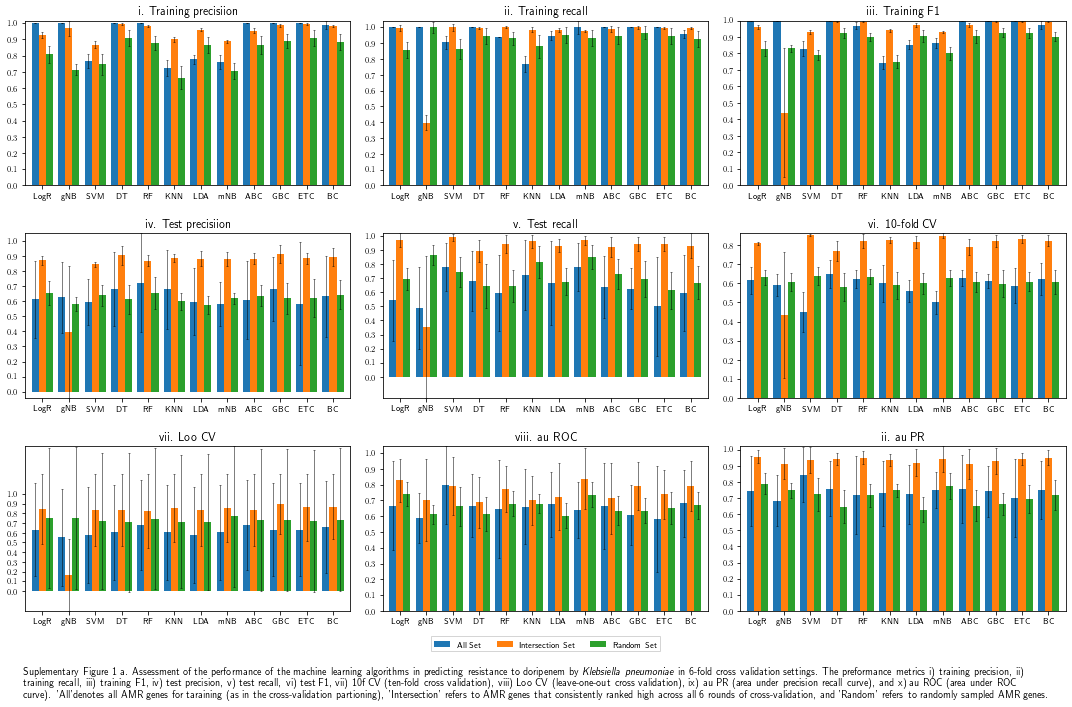

All Set Results ertapenem Klebsiella


classifier  tr_precision_avg_as  tr_precision_stdev_as  tr_recall_avg_as  \
0        LogR                1.000                  0.000             1.000   
1         gNB                1.000                  0.000             1.000   
2         SVM                0.829                  0.017             0.702   
3          DT                1.000                  0.000             1.000   
4          RF                0.987                  0.014             0.978   
5         KNN                0.862                  0.046             0.782   
6         LDA                0.836                  0.044             0.844   
7         mNB                0.821                  0.014             0.795   
8         ABC                1.000                  0.000             1.000   
9         GBC                1.000                  0.000             1.000   
10        ETC                1.000                  0.000             1.000   
11         BC                0.995                  0.011             0.933   

    tr_recall_stdev_as  tr_f1_avg_as  tr_f1_stdev_as  te_precision_avg_as  \
0                0.000         1.000           0.000                0.730   
1                0.000         1.000           0.000                0.590   
2                0.088         0.757           0.044                0.662   
3                0.000         1.000           0.000                0.829   
4                0.011         0.982           0.007                0.748   
5                0.089         0.817           0.052                0.707   
6                0.012         0.840           0.019                0.643   
7                0.054         0.807           0.033                0.688   
8                0.000         1.000           0.000                0.791   
9                0.000         1.000           0.000                0.750   
10               0.000         1.000           0.000                0.752   
11               0.028         0.963           0.014                0.756   

    te_precision_stdev_as  te_recall_avg_as  ...  te_f1_avg_as  \
0                   0.200             0.670  ...         0.672   
1                   0.166             0.601  ...         0.575   
2                   0.117             0.580  ...         0.597   
3                   0.167             0.688  ...         0.745   
4                   0.175             0.598  ...         0.646   
5                   0.138             0.601  ...         0.633   
6                   0.156             0.619  ...         0.624   
7                   0.101             0.619  ...         0.636   
8                   0.171             0.652  ...         0.690   
9                   0.147             0.669  ...         0.695   
10                  0.112             0.690  ...         0.702   
11                  0.086             0.643  ...         0.683   

    te_f1_stdev_as  Tf_CV_Avg_as  Tf_CV_stdev_as  au_ROC_avg_as  \
0            0.164         0.659           0.055          0.801   
1            0.195         0.585           0.068          0.582   
2            0.187         0.526           0.036          0.762   
3            0.179         0.704           0.077          0.778   
4            0.235         0.672           0.052          0.798   
5            0.165         0.635           0.041          0.796   
6            0.172         0.593           0.066          0.759   
7            0.150         0.584           0.057          0.688   
8            0.157         0.697           0.058          0.765   
9            0.179         0.704           0.059          0.816   
10           0.225         0.671           0.058          0.799   
11           0.156         0.664           0.047          0.798   

    au_ROC_stdev_as  au_PR_avg_as  au_PR_stdev_as  Loo_CV_as  Loo_stdev_as  
0             0.169         0.820           0.167      0.700         0.458  
1             0.182         0.696           0.127      0.633         0.482  
2          

Intersection Set Results ertapenem Klebsiella


classifier  tr_precision_avg_is  tr_precision_stdev_is  tr_recall_avg_is  \
0        LogR                0.929                  0.011             0.987   
1         gNB                1.000                  0.000             0.616   
2         SVM                0.898                  0.008             1.000   
3          DT                0.994                  0.004             0.987   
4          RF                0.976                  0.007             0.995   
5         KNN                0.931                  0.007             0.953   
6         LDA                0.959                  0.008             0.982   
7         mNB                0.918                  0.008             0.924   
8         ABC                0.976                  0.007             0.985   
9         GBC                0.986                  0.007             0.991   
10        ETC                0.994                  0.004             0.987   
11         BC                0.983                  0.006             0.989   

    tr_recall_stdev_is  tr_f1_avg_is  tr_f1_stdev_is  te_precision_avg_is  \
0                0.005         0.957           0.007                0.905   
1                0.049         0.762           0.036                0.985   
2                0.000         0.946           0.005                0.890   
3                0.005         0.990           0.002                0.923   
4                0.006         0.986           0.003                0.935   
5                0.012         0.941           0.005                0.924   
6                0.007         0.970           0.006                0.902   
7                0.017         0.921           0.011                0.917   
8                0.012         0.980           0.007                0.914   
9                0.005         0.989           0.004                0.923   
10               0.005         0.990           0.002                0.918   
11               0.008         0.986           0.005                0.917   

    te_precision_stdev_is  te_recall_avg_is  ...  te_f1_avg_is  \
0                   0.037             0.964  ...         0.933   
1                   0.023             0.588  ...         0.732   
2                   0.026             0.995  ...         0.939   
3                   0.047             0.912  ...         0.917   
4                   0.044             0.949  ...         0.942   
5                   0.050             0.908  ...         0.915   
6                   0.032             0.938  ...         0.919   
7                   0.055             0.897  ...         0.906   
8                   0.021             0.928  ...         0.920   
9                   0.035             0.964  ...         0.942   
10                  0.038             0.959  ...         0.938   
11                  0.038             0.944  ...         0.929   

    te_f1_stdev_is  Tf_CV_Avg_is  Tf_CV_stdev_is  au_ROC_avg_is  \
0            0.019         0.862           0.017          0.917   
1            0.064         0.669           0.047          0.910   
2            0.014         0.872           0.012          0.907   
3            0.036         0.842           0.024          0.793   
4            0.035         0.858           0.024          0.880   
5            0.034         0.842           0.019          0.852   
6            0.022         0.852           0.014          0.890   
7            0.051         0.832           0.022          0.858   
8            0.031         0.848           0.022          0.917   
9            0.022         0.853           0.011          0.926   
10           0.021         0.875           0.009          0.898   
11           0.023         0.838           0.020          0.892   

    au_ROC_stdev_is  au_PR_avg_is  au_PR_stdev_is  Loo_CV_is  Loo_stdev_is  
0             0.051         0.975           0.019      0.879         0.327  
1             0.040         0.978           0.010      0.640         0.480  
2          

Random Set Results ertapenem Klebsiella


classifier  tr_precision_avg_rs  tr_precision_stdev_rs  tr_recall_avg_rs  \
0        LogR                0.832                  0.061             0.779   
1         gNB                0.824                  0.169             0.656   
2         SVM                0.803                  0.062             0.657   
3          DT                0.972                  0.027             0.904   
4          RF                0.944                  0.030             0.898   
5         KNN                0.787                  0.060             0.804   
6         LDA                0.867                  0.040             0.849   
7         mNB                0.769                  0.040             0.719   
8         ABC                0.858                  0.046             0.841   
9         GBC                0.926                  0.041             0.893   
10        ETC                0.972                  0.027             0.904   
11         BC                0.941                  0.024             0.902   

    tr_recall_stdev_rs  tr_f1_avg_rs  tr_f1_stdev_rs  te_precision_avg_rs  \
0                0.064         0.803           0.055                0.678   
1                0.243         0.650           0.099                0.556   
2                0.116         0.713           0.063                0.686   
3                0.038         0.936           0.021                0.735   
4                0.039         0.919           0.022                0.736   
5                0.060         0.790           0.025                0.640   
6                0.051         0.857           0.038                0.679   
7                0.065         0.740           0.041                0.677   
8                0.061         0.848           0.045                0.658   
9                0.044         0.907           0.024                0.704   
10               0.038         0.936           0.021                0.747   
11               0.031         0.920           0.021                0.715   

    te_precision_stdev_rs  te_recall_avg_rs  ...  te_f1_avg_rs  \
0                   0.091             0.613  ...         0.632   
1                   0.202             0.510  ...         0.460   
2                   0.114             0.522  ...         0.570   
3                   0.081             0.616  ...         0.656   
4                   0.081             0.608  ...         0.646   
5                   0.097             0.662  ...         0.636   
6                   0.085             0.636  ...         0.645   
7                   0.065             0.615  ...         0.632   
8                   0.068             0.622  ...         0.629   
9                   0.058             0.638  ...         0.654   
10                  0.079             0.644  ...         0.672   
11                  0.064             0.646  ...         0.666   

    te_f1_stdev_rs  Tf_CV_Avg_rs  Tf_CV_stdev_rs  Loo_CV_Avg_rs  \
0            0.079         0.642           0.052          0.721   
1            0.181         0.566           0.066          0.658   
2            0.070         0.635           0.031          0.676   
3            0.061         0.652           0.048          0.781   
4            0.062         0.667           0.041          0.773   
5            0.055         0.612           0.051          0.717   
6            0.072         0.631           0.048          0.738   
7            0.038         0.638           0.037          0.707   
8            0.072         0.635           0.051          0.730   
9            0.059         0.655           0.047          0.763   
10           0.064         0.663           0.040          0.789   
11           0.054         0.654           0.051          0.774   

    Loo_CV_stdev_rs  au_ROC_avg_rs  au_ROC_stdev_rs  au_PR_avg_rs  \
0             0.716          0.733            0.087         0.752   
1             0.549          0.657            0.074         0.703   
2             0.681          0.707 

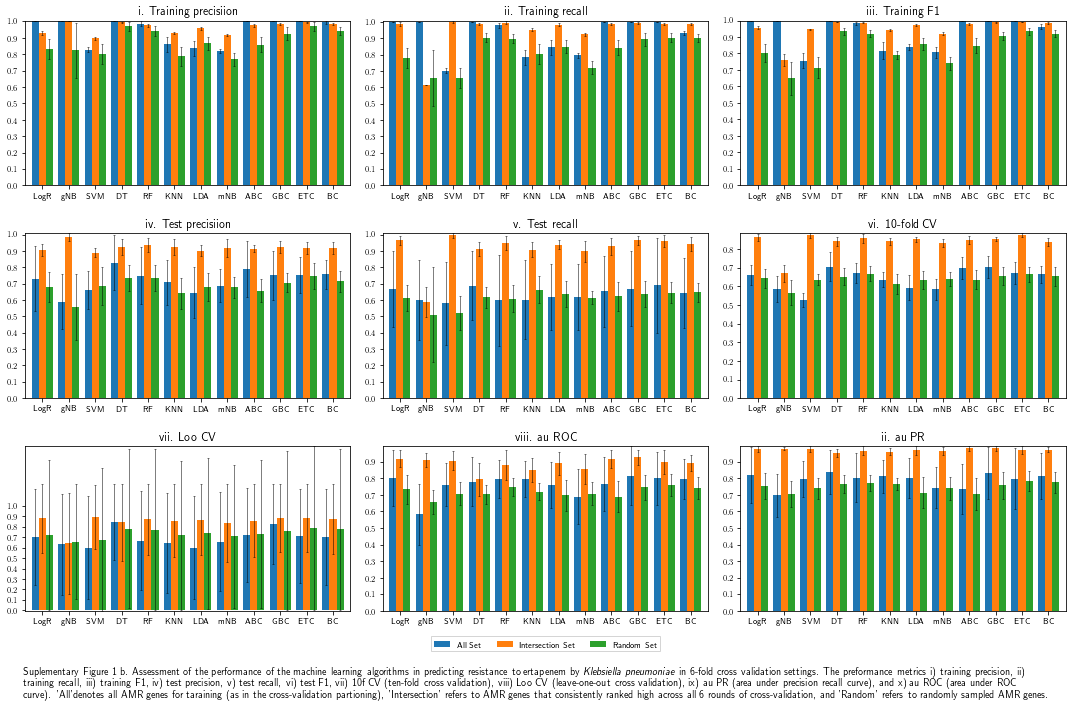

All Set Results imipenem Klebsiella


classifier  tr_precision_avg_as  tr_precision_stdev_as  tr_recall_avg_as  \
0        LogR                1.000                  0.000             1.000   
1         gNB                1.000                  0.000             1.000   
2         SVM                0.853                  0.038             0.637   
3          DT                1.000                  0.000             1.000   
4          RF                0.995                  0.013             0.958   
5         KNN                0.818                  0.037             0.789   
6         LDA                0.797                  0.030             0.805   
7         mNB                0.774                  0.042             0.768   
8         ABC                1.000                  0.000             1.000   
9         GBC                1.000                  0.000             1.000   
10        ETC                1.000                  0.000             1.000   
11         BC                0.995                  0.012             0.947   

    tr_recall_stdev_as  tr_f1_avg_as  tr_f1_stdev_as  te_precision_avg_as  \
0                0.000         1.000           0.000                0.671   
1                0.000         1.000           0.000                0.720   
2                0.054         0.728           0.042                0.683   
3                0.000         1.000           0.000                0.720   
4                0.032         0.976           0.017                0.755   
5                0.057         0.802           0.022                0.614   
6                0.031         0.801           0.028                0.590   
7                0.031         0.771           0.028                0.620   
8                0.000         1.000           0.000                0.742   
9                0.000         1.000           0.000                0.869   
10               0.000         1.000           0.000                0.715   
11               0.033         0.970           0.013                0.822   

    te_precision_stdev_as  te_recall_avg_as  ...  te_f1_avg_as  \
0                   0.101             0.683  ...         0.667   
1                   0.158             0.623  ...         0.651   
2                   0.238             0.500  ...         0.570   
3                   0.174             0.663  ...         0.674   
4                   0.224             0.576  ...         0.634   
5                   0.203             0.583  ...         0.592   
6                   0.179             0.579  ...         0.580   
7                   0.176             0.659  ...         0.634   
8                   0.091             0.730  ...         0.729   
9                   0.149             0.738  ...         0.790   
10                  0.158             0.655  ...         0.672   
11                  0.145             0.659  ...         0.708   

    te_f1_stdev_as  Tf_CV_Avg_as  Tf_CV_stdev_as  au_ROC_avg_as  \
0            0.172         0.615           0.049          0.770   
1            0.086         0.605           0.048          0.663   
2            0.267         0.327           0.231          0.440   
3            0.185         0.629           0.056          0.694   
4            0.189         0.599           0.041          0.730   
5            0.222         0.542           0.025          0.693   
6            0.211         0.508           0.078          0.703   
7            0.190         0.445           0.102          0.636   
8            0.101         0.697           0.039          0.774   
9            0.101         0.714           0.053          0.877   
10           0.161         0.631           0.036          0.782   
11           0.164         0.674           0.049          0.853   

    au_ROC_stdev_as  au_PR_avg_as  au_PR_stdev_as  Loo_CV_as  Loo_stdev_as  
0             0.170         0.818           0.128      0.618         0.486  
1             0.089         0.764           0.076      0.658         0.474  
2          

Intersection Set Results imipenem Klebsiella


classifier  tr_precision_avg_is  tr_precision_stdev_is  tr_recall_avg_is  \
0        LogR                0.936                  0.007             0.964   
1         gNB                1.000                  0.000             0.629   
2         SVM                0.885                  0.013             0.987   
3          DT                0.987                  0.005             0.976   
4          RF                0.975                  0.009             0.979   
5         KNN                0.944                  0.013             0.859   
6         LDA                0.959                  0.017             0.956   
7         mNB                0.932                  0.011             0.774   
8         ABC                0.956                  0.017             0.963   
9         GBC                0.969                  0.011             0.983   
10        ETC                0.987                  0.005             0.976   
11         BC                0.975                  0.010             0.979   

    tr_recall_stdev_is  tr_f1_avg_is  tr_f1_stdev_is  te_precision_avg_is  \
0                0.011         0.950           0.008                0.884   
1                0.110         0.768           0.077                0.937   
2                0.007         0.933           0.010                0.843   
3                0.010         0.982           0.004                0.895   
4                0.010         0.977           0.006                0.896   
5                0.019         0.900           0.013                0.930   
6                0.016         0.957           0.012                0.904   
7                0.019         0.845           0.013                0.908   
8                0.009         0.959           0.011                0.897   
9                0.008         0.976           0.009                0.894   
10               0.010         0.982           0.004                0.907   
11               0.017         0.977           0.009                0.879   

    te_precision_stdev_is  te_recall_avg_is  ...  te_f1_avg_is  \
0                   0.049             0.924  ...         0.902   
1                   0.069             0.607  ...         0.730   
2                   0.044             0.952  ...         0.893   
3                   0.039             0.868  ...         0.879   
4                   0.062             0.903  ...         0.897   
5                   0.047             0.806  ...         0.862   
6                   0.061             0.875  ...         0.888   
7                   0.060             0.758  ...         0.825   
8                   0.063             0.876  ...         0.885   
9                   0.053             0.910  ...         0.901   
10                  0.064             0.910  ...         0.907   
11                  0.064             0.876  ...         0.876   

    te_f1_stdev_is  Tf_CV_Avg_is  Tf_CV_stdev_is  au_ROC_avg_is  \
0            0.028         0.786           0.017          0.899   
1            0.049         0.623           0.095          0.811   
2            0.033         0.752           0.019          0.866   
3            0.049         0.751           0.025          0.740   
4            0.045         0.758           0.034          0.860   
5            0.053         0.692           0.037          0.834   
6            0.039         0.743           0.029          0.848   
7            0.073         0.711           0.009          0.843   
8            0.052         0.779           0.023          0.843   
9            0.037         0.774           0.026          0.879   
10           0.046         0.759           0.027          0.820   
11           0.053         0.757           0.015          0.844   

    au_ROC_stdev_is  au_PR_avg_is  au_PR_stdev_is  Loo_CV_is  Loo_stdev_is  
0             0.069         0.970           0.026      0.842         0.365  
1             0.078         0.945           0.030      0.612         0.487  
2          

Random Set Results imipenem Klebsiella


classifier  tr_precision_avg_rs  tr_precision_stdev_rs  tr_recall_avg_rs  \
0        LogR                0.815                  0.052             0.778   
1         gNB                0.650                  0.102             0.922   
2         SVM                0.799                  0.090             0.601   
3          DT                0.952                  0.040             0.875   
4          RF                0.900                  0.034             0.895   
5         KNN                0.758                  0.053             0.812   
6         LDA                0.849                  0.051             0.869   
7         mNB                0.731                  0.047             0.738   
8         ABC                0.840                  0.047             0.857   
9         GBC                0.912                  0.045             0.877   
10        ETC                0.952                  0.040             0.875   
11         BC                0.904                  0.039             0.884   

    tr_recall_stdev_rs  tr_f1_avg_rs  tr_f1_stdev_rs  te_precision_avg_rs  \
0                0.062         0.793           0.036                0.635   
1                0.157         0.728           0.053                0.465   
2                0.085         0.677           0.052                0.694   
3                0.050         0.910           0.032                0.662   
4                0.034         0.896           0.025                0.636   
5                0.070         0.779           0.025                0.634   
6                0.048         0.857           0.035                0.628   
7                0.062         0.731           0.040                0.606   
8                0.054         0.847           0.036                0.618   
9                0.061         0.892           0.034                0.663   
10               0.050         0.910           0.032                0.664   
11               0.037         0.892           0.030                0.640   

    te_precision_stdev_rs  te_recall_avg_rs  ...  te_f1_avg_rs  \
0                   0.055             0.600  ...         0.600   
1                   0.103             0.816  ...         0.587   
2                   0.079             0.528  ...         0.582   
3                   0.085             0.569  ...         0.596   
4                   0.064             0.558  ...         0.581   
5                   0.091             0.713  ...         0.659   
6                   0.089             0.648  ...         0.626   
7                   0.042             0.627  ...         0.605   
8                   0.076             0.638  ...         0.612   
9                   0.085             0.601  ...         0.614   
10                  0.088             0.576  ...         0.602   
11                  0.102             0.551  ...         0.575   

    te_f1_stdev_rs  Tf_CV_Avg_rs  Tf_CV_stdev_rs  Loo_CV_Avg_rs  \
0            0.073         0.611           0.046          0.697   
1            0.152         0.512           0.034          0.671   
2            0.072         0.600           0.047          0.628   
3            0.094         0.620           0.057          0.726   
4            0.050         0.615           0.036          0.715   
5            0.069         0.571           0.049          0.712   
6            0.097         0.595           0.043          0.702   
7            0.042         0.580           0.045          0.679   
8            0.084         0.598           0.038          0.693   
9            0.088         0.621           0.041          0.727   
10           0.092         0.621           0.035          0.734   
11           0.079         0.624           0.045          0.714   

    Loo_CV_stdev_rs  au_ROC_avg_rs  au_ROC_stdev_rs  au_PR_avg_rs  \
0             0.678          0.668            0.096         0.698   
1             0.620          0.537            0.058         0.692   
2             0.627          0.545 

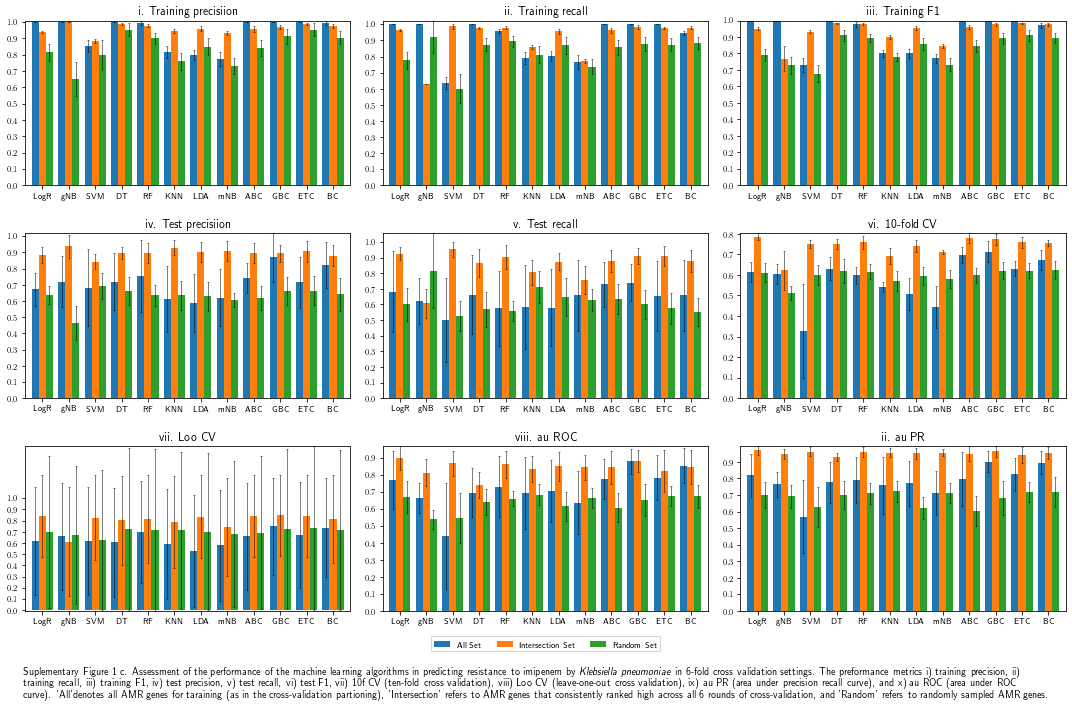

All Set Results meropenem Klebsiella


classifier  tr_precision_avg_as  tr_precision_stdev_as  tr_recall_avg_as  \
0        LogR                1.000                  0.000             1.000   
1         gNB                1.000                  0.000             1.000   
2         SVM                0.860                  0.030             0.760   
3          DT                1.000                  0.000             1.000   
4          RF                0.988                  0.014             0.939   
5         KNN                0.853                  0.034             0.733   
6         LDA                0.843                  0.023             0.838   
7         mNB                0.795                  0.032             0.815   
8         ABC                1.000                  0.000             1.000   
9         GBC                1.000                  0.000             1.000   
10        ETC                1.000                  0.000             1.000   
11         BC                0.991                  0.015             0.974   

    tr_recall_stdev_as  tr_f1_avg_as  tr_f1_stdev_as  te_precision_avg_as  \
0                0.000         1.000           0.000                0.849   
1                0.000         1.000           0.000                0.835   
2                0.037         0.806           0.021                0.779   
3                0.000         1.000           0.000                0.813   
4                0.023         0.963           0.007                0.816   
5                0.036         0.788           0.025                0.762   
6                0.014         0.840           0.013                0.772   
7                0.018         0.804           0.015                0.749   
8                0.000         1.000           0.000                0.779   
9                0.000         1.000           0.000                0.878   
10               0.000         1.000           0.000                0.819   
11               0.022         0.982           0.016                0.879   

    te_precision_stdev_as  te_recall_avg_as  ...  te_f1_avg_as  \
0                   0.104             0.755  ...         0.796   
1                   0.107             0.766  ...         0.798   
2                   0.086             0.709  ...         0.741   
3                   0.093             0.780  ...         0.784   
4                   0.096             0.738  ...         0.773   
5                   0.102             0.751  ...         0.756   
6                   0.059             0.781  ...         0.775   
7                   0.065             0.740  ...         0.743   
8                   0.078             0.841  ...         0.808   
9                   0.108             0.812  ...         0.838   
10                  0.128             0.783  ...         0.796   
11                  0.110             0.841  ...         0.855   

    te_f1_stdev_as  Tf_CV_Avg_as  Tf_CV_stdev_as  au_ROC_avg_as  \
0            0.052         0.769           0.021          0.866   
1            0.082         0.682           0.038          0.802   
2            0.071         0.689           0.025          0.851   
3            0.044         0.767           0.035          0.787   
4            0.073         0.749           0.038          0.820   
5            0.104         0.714           0.027          0.820   
6            0.054         0.706           0.022          0.842   
7            0.074         0.722           0.023          0.778   
8            0.066         0.757           0.032          0.843   
9            0.043         0.797           0.039          0.900   
10           0.085         0.753           0.038          0.877   
11           0.066         0.792           0.046          0.890   

    au_ROC_stdev_as  au_PR_avg_as  au_PR_stdev_as  Loo_CV_as  Loo_stdev_as  
0             0.041         0.868           0.053      0.804         0.397  
1             0.082         0.859           0.067      0.783         0.412  
2          

Intersection Set Results meropenem Klebsiella


classifier  tr_precision_avg_is  tr_precision_stdev_is  tr_recall_avg_is  \
0        LogR                0.969                  0.006             0.972   
1         gNB                1.000                  0.000             0.501   
2         SVM                0.922                  0.012             0.967   
3          DT                0.993                  0.003             0.984   
4          RF                0.980                  0.008             0.991   
5         KNN                0.908                  0.014             0.860   
6         LDA                0.980                  0.008             0.989   
7         mNB                0.874                  0.004             0.832   
8         ABC                0.971                  0.007             0.972   
9         GBC                0.987                  0.004             0.988   
10        ETC                0.993                  0.003             0.984   
11         BC                0.982                  0.008             0.987   

    tr_recall_stdev_is  tr_f1_avg_is  tr_f1_stdev_is  te_precision_avg_is  \
0                0.007         0.971           0.005                0.907   
1                0.064         0.665           0.055                0.944   
2                0.013         0.944           0.011                0.864   
3                0.007         0.989           0.005                0.862   
4                0.009         0.985           0.007                0.863   
5                0.015         0.884           0.005                0.872   
6                0.007         0.985           0.005                0.866   
7                0.010         0.853           0.004                0.872   
8                0.008         0.971           0.007                0.903   
9                0.010         0.987           0.006                0.881   
10               0.007         0.989           0.005                0.862   
11               0.013         0.984           0.006                0.900   

    te_precision_stdev_is  te_recall_avg_is  ...  te_f1_avg_is  \
0                   0.055             0.899  ...         0.902   
1                   0.078             0.470  ...         0.624   
2                   0.037             0.919  ...         0.889   
3                   0.091             0.785  ...         0.819   
4                   0.078             0.859  ...         0.860   
5                   0.055             0.805  ...         0.836   
6                   0.067             0.826  ...         0.843   
7                   0.031             0.812  ...         0.840   
8                   0.051             0.906  ...         0.903   
9                   0.085             0.892  ...         0.885   
10                  0.059             0.900  ...         0.879   
11                  0.070             0.865  ...         0.881   

    te_f1_stdev_is  Tf_CV_Avg_is  Tf_CV_stdev_is  au_ROC_avg_is  \
0            0.043         0.840           0.011          0.928   
1            0.093         0.604           0.052          0.895   
2            0.022         0.824           0.010          0.905   
3            0.053         0.788           0.033          0.746   
4            0.053         0.807           0.033          0.875   
5            0.027         0.777           0.012          0.850   
6            0.028         0.756           0.026          0.826   
7            0.025         0.786           0.010          0.870   
8            0.023         0.839           0.023          0.901   
9            0.044         0.817           0.033          0.890   
10           0.037         0.811           0.021          0.866   
11           0.041         0.794           0.025          0.898   

    au_ROC_stdev_is  au_PR_avg_is  au_PR_stdev_is  Loo_CV_is  Loo_stdev_is  
0             0.034         0.963           0.019      0.867         0.340  
1             0.036         0.943           0.031      0.610         0.488  
2          

Random Set Results meropenem Klebsiella


classifier  tr_precision_avg_rs  tr_precision_stdev_rs  tr_recall_avg_rs  \
0        LogR                0.837                  0.038             0.785   
1         gNB                0.753                  0.140             0.768   
2         SVM                0.835                  0.045             0.706   
3          DT                0.942                  0.022             0.912   
4          RF                0.919                  0.033             0.894   
5         KNN                0.787                  0.040             0.834   
6         LDA                0.865                  0.035             0.846   
7         mNB                0.778                  0.043             0.745   
8         ABC                0.859                  0.036             0.834   
9         GBC                0.905                  0.028             0.891   
10        ETC                0.942                  0.022             0.912   
11         BC                0.911                  0.029             0.919   

    tr_recall_stdev_rs  tr_f1_avg_rs  tr_f1_stdev_rs  te_precision_avg_rs  \
0                0.035         0.810           0.031                0.758   
1                0.250         0.688           0.112                0.580   
2                0.048         0.763           0.035                0.774   
3                0.031         0.926           0.024                0.756   
4                0.027         0.906           0.020                0.765   
5                0.059         0.807           0.025                0.700   
6                0.036         0.854           0.032                0.745   
7                0.051         0.759           0.030                0.737   
8                0.035         0.846           0.032                0.743   
9                0.035         0.897           0.025                0.762   
10               0.031         0.926           0.024                0.772   
11               0.021         0.914           0.021                0.737   

    te_precision_stdev_rs  te_recall_avg_rs  ...  te_f1_avg_rs  \
0                   0.043             0.708  ...         0.727   
1                   0.109             0.655  ...         0.550   
2                   0.057             0.635  ...         0.693   
3                   0.046             0.673  ...         0.701   
4                   0.057             0.674  ...         0.705   
5                   0.061             0.771  ...         0.727   
6                   0.041             0.723  ...         0.726   
7                   0.041             0.704  ...         0.715   
8                   0.035             0.715  ...         0.721   
9                   0.048             0.722  ...         0.733   
10                  0.042             0.697  ...         0.723   
11                  0.056             0.710  ...         0.715   

    te_f1_stdev_rs  Tf_CV_Avg_rs  Tf_CV_stdev_rs  Loo_CV_Avg_rs  \
0            0.033         0.714           0.040          0.773   
1            0.188         0.579           0.054          0.720   
2            0.036         0.711           0.034          0.752   
3            0.054         0.711           0.034          0.787   
4            0.026         0.714           0.029          0.794   
5            0.042         0.681           0.040          0.777   
6            0.038         0.708           0.025          0.779   
7            0.024         0.701           0.033          0.764   
8            0.035         0.699           0.022          0.772   
9            0.045         0.724           0.030          0.799   
10           0.041         0.712           0.035          0.805   
11           0.037         0.713           0.032          0.799   

    Loo_CV_stdev_rs  au_ROC_avg_rs  au_ROC_stdev_rs  au_PR_avg_rs  \
0             0.770          0.806            0.038         0.804   
1             0.654          0.715            0.076         0.753   
2             0.755          0.811 

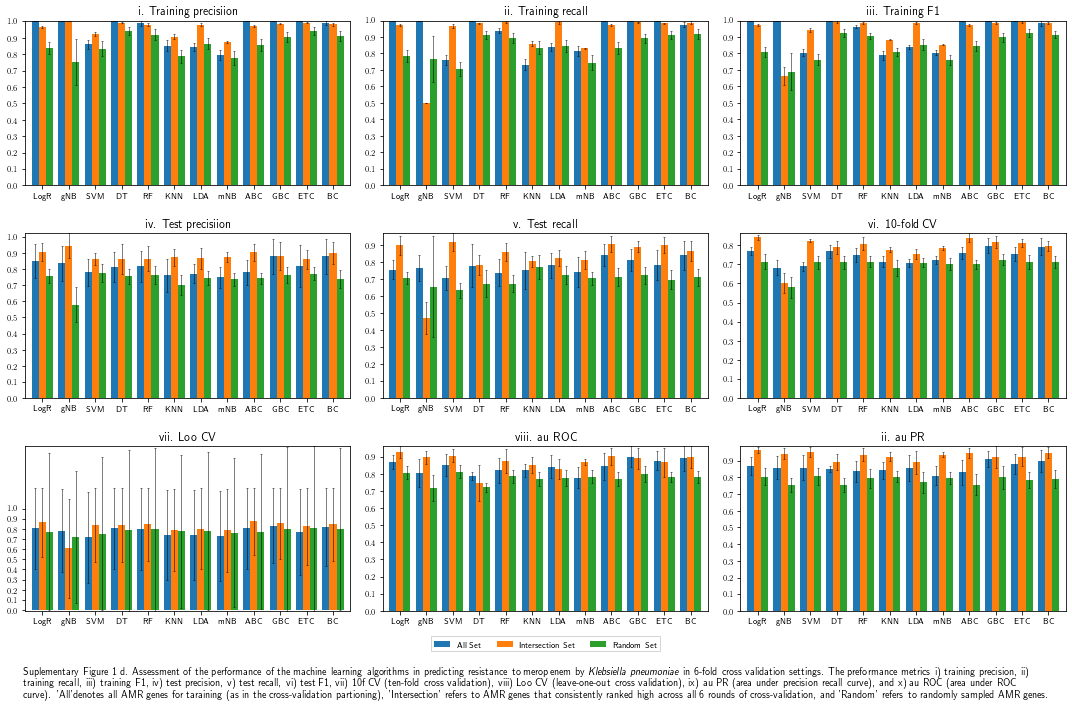

In [3]:
#All set, Intersection set and Random set performance for Klebsiella pneumoniae

#Dictionary of antibiotics
antb_SN = {'doripenem': '1 a', 'ertapenem': '1 b', 'imipenem': '1 c', 'meropenem': '1 d'}

#import pandas
import pandas as pd

for antb, SN in antb_SN.items():
    
    #Acronym for Klebsiella pneumoniae
    bacteria = 'Klebsiella'
    
    #Italicized full name bacteria for fig output
    italic_name = r"\textit{Klebsiella pneumoniae}"
    
    #Figure plot number
    supplementary_fig_no = SN
    
    #Import gene-ast data from github repository
    file_name = f'https://github.com/Janaksunuwar/AMRprediction_HomologyModeling_Docking/raw/main/Data/Final_Gene_AST_matrix_{bacteria}_{antb}_qc70_pi30.csv'

    #no of validation
    validation_no = 6
    
    #Result out
    file_all_out = f"{bacteria}_{antb}_Complete_Results_{validation_no}-fold_CV.csv"
    
    #read the gene-ast data
    data_ = pd.read_csv(file_name)
    
    #Put all the susceptible class in a separate dataset
    susceptible = data_.loc[data_[antb] == 0]
    no_of_sus = len(susceptible.index)
    
    #Select equal number of resistant dataset
    resistant = data_.loc[data_[antb] == 1].sample(n=no_of_sus, random_state=42)
    
    #Concatenate both dataframes again
    data = pd.concat([resistant, susceptible])
    
    ML_Run()

All Set Results doripenem EcS


classifier  tr_precision_avg_as  tr_precision_stdev_as  tr_recall_avg_as  \
0        LogR                1.000                  0.000             1.000   
1         gNB                1.000                  0.000             1.000   
2         SVM                0.882                  0.171             0.683   
3          DT                1.000                  0.000             1.000   
4          RF                1.000                  0.000             0.943   
5         KNN                0.668                  0.091             0.672   
6         LDA                0.768                  0.096             0.738   
7         mNB                0.916                  0.070             1.000   
8         ABC                1.000                  0.000             1.000   
9         GBC                1.000                  0.000             1.000   
10        ETC                1.000                  0.000             1.000   
11         BC                0.987                  0.031             0.927   

    tr_recall_stdev_as  tr_f1_avg_as  tr_f1_stdev_as  te_precision_avg_as  \
0                0.000         1.000           0.000                0.722   
1                0.000         1.000           0.000                0.778   
2                0.460         0.644           0.379                0.400   
3                0.000         1.000           0.000                0.767   
4                0.044         0.970           0.023                0.750   
5                0.061         0.667           0.060                0.597   
6                0.170         0.750           0.129                0.736   
7                0.000         0.955           0.038                0.750   
8                0.000         1.000           0.000                0.806   
9                0.000         1.000           0.000                0.778   
10               0.000         1.000           0.000                0.833   
11               0.068         0.954           0.032                0.750   

    te_precision_stdev_as  te_recall_avg_as  ...  te_f1_avg_as  \
0                   0.443             0.556  ...         0.611   
1                   0.251             0.639  ...         0.689   
2                   0.389             0.500  ...         0.406   
3                   0.408             0.667  ...         0.681   
4                   0.418             0.528  ...         0.606   
5                   0.396             0.556  ...         0.515   
6                   0.318             0.583  ...         0.600   
7                   0.294             0.611  ...         0.589   
8                   0.221             0.722  ...         0.739   
9                   0.404             0.417  ...         0.528   
10                  0.279             0.722  ...         0.744   
11                  0.418             0.639  ...         0.683   

    te_f1_stdev_as  Tf_CV_Avg_as  Tf_CV_stdev_as  au_ROC_avg_as  \
0            0.359         0.664           0.051          0.889   
1            0.191         0.608           0.065          0.722   
2            0.341         0.028           0.048          0.167   
3            0.367         0.617           0.101          0.750   
4            0.340         0.583           0.110          0.812   
5            0.297         0.539           0.090          0.576   
6            0.187         0.405           0.134          0.750   
7            0.147         0.208           0.074          0.764   
8            0.169         0.575           0.096          0.833   
9            0.267         0.594           0.115          0.806   
10           0.200         0.622           0.102          0.861   
11           0.382         0.620           0.046          0.778   

    au_ROC_stdev_as  au_PR_avg_as  au_PR_stdev_as  Loo_CV_as  Loo_stdev_as  
0             0.172         0.854           0.244      0.714         0.452  
1             0.172         0.796           0.170      0.714         0.452  
2          

Intersection Set Results doripenem EcS


classifier  tr_precision_avg_is  tr_precision_stdev_is  tr_recall_avg_is  \
0        LogR                1.000                  0.000             1.000   
1         gNB                0.986                  0.034             1.000   
2         SVM                1.000                  0.000             1.000   
3          DT                1.000                  0.000             1.000   
4          RF                1.000                  0.000             1.000   
5         KNN                0.985                  0.037             0.771   
6         LDA                1.000                  0.000             1.000   
7         mNB                0.973                  0.041             1.000   
8         ABC                1.000                  0.000             1.000   
9         GBC                1.000                  0.000             1.000   
10        ETC                1.000                  0.000             1.000   
11         BC                1.000                  0.000             0.971   

    tr_recall_stdev_is  tr_f1_avg_is  tr_f1_stdev_is  te_precision_avg_is  \
0                0.000         1.000           0.000                1.000   
1                0.000         0.993           0.018                0.958   
2                0.000         1.000           0.000                1.000   
3                0.000         1.000           0.000                0.750   
4                0.000         1.000           0.000                1.000   
5                0.092         0.861           0.048                0.917   
6                0.000         1.000           0.000                0.861   
7                0.000         0.986           0.021                0.875   
8                0.000         1.000           0.000                0.861   
9                0.000         1.000           0.000                0.694   
10               0.000         1.000           0.000                1.000   
11               0.045         0.985           0.024                0.861   

    te_precision_stdev_is  te_recall_avg_is  ...  te_f1_avg_is  \
0                   0.000             0.750  ...         0.828   
1                   0.102             0.861  ...         0.887   
2                   0.000             0.833  ...         0.883   
3                   0.274             0.639  ...         0.673   
4                   0.000             0.806  ...         0.878   
5                   0.204             0.750  ...         0.811   
6                   0.221             0.750  ...         0.739   
7                   0.209             0.917  ...         0.893   
8                   0.221             0.861  ...         0.850   
9                   0.245             0.694  ...         0.673   
10                  0.000             0.667  ...         0.772   
11                  0.221             0.667  ...         0.711   

    te_f1_stdev_is  Tf_CV_Avg_is  Tf_CV_stdev_is  au_ROC_avg_is  \
0            0.211         0.869           0.032          1.000   
1            0.138         0.938           0.038          0.970   
2            0.204         0.847           0.042          1.000   
3            0.197         0.808           0.085          0.736   
4            0.142         0.854           0.015          0.972   
5            0.244         0.846           0.055          0.951   
6            0.169         0.786           0.052          0.951   
7            0.201         0.946           0.022          0.970   
8            0.197         0.853           0.047          0.969   
9            0.197         0.817           0.040          0.840   
10           0.200         0.864           0.034          1.000   
11           0.195         0.828           0.031          0.942   

    au_ROC_stdev_is  au_PR_avg_is  au_PR_stdev_is  Loo_CV_is  Loo_stdev_is  
0             0.000         1.000           0.000      0.925         0.263  
1             0.048         0.949           0.086      0.925         0.263  
2          

Random Set Results doripenem EcS


classifier  tr_precision_avg_rs  tr_precision_stdev_rs  tr_recall_avg_rs  \
0        LogR                0.884                  0.061             0.906   
1         gNB                0.874                  0.101             0.791   
2         SVM                0.704                  0.192             0.722   
3          DT                0.975                  0.060             0.973   
4          RF                0.967                  0.064             0.909   
5         KNN                0.618                  0.045             0.846   
6         LDA                0.943                  0.068             0.957   
7         mNB                0.802                  0.062             0.851   
8         ABC                0.959                  0.069             0.971   
9         GBC                0.970                  0.067             0.981   
10        ETC                0.975                  0.060             0.973   
11         BC                0.954                  0.065             0.939   

    tr_recall_stdev_rs  tr_f1_avg_rs  tr_f1_stdev_rs  te_precision_avg_rs  \
0                0.069         0.891           0.059                0.650   
1                0.200         0.787           0.097                0.420   
2                0.097         0.688           0.141                0.535   
3                0.068         0.972           0.051                0.732   
4                0.059         0.934           0.051                0.672   
5                0.100         0.708           0.052                0.566   
6                0.055         0.947           0.051                0.633   
7                0.095         0.814           0.057                0.617   
8                0.051         0.962           0.057                0.616   
9                0.059         0.973           0.050                0.680   
10               0.068         0.972           0.051                0.755   
11               0.058         0.942           0.041                0.656   

    te_precision_stdev_rs  te_recall_avg_rs  ...  te_f1_avg_rs  \
0                   0.109             0.603  ...         0.579   
1                   0.219             0.519  ...         0.437   
2                   0.198             0.619  ...         0.515   
3                   0.100             0.686  ...         0.662   
4                   0.147             0.525  ...         0.550   
5                   0.081             0.789  ...         0.626   
6                   0.124             0.653  ...         0.611   
7                   0.136             0.633  ...         0.564   
8                   0.148             0.586  ...         0.559   
9                   0.153             0.669  ...         0.634   
10                  0.124             0.650  ...         0.653   
11                  0.097             0.606  ...         0.591   

    te_f1_stdev_rs  Tf_CV_Avg_rs  Tf_CV_stdev_rs  Loo_CV_Avg_rs  \
0            0.076         0.563           0.077          0.724   
1            0.250         0.523           0.085          0.616   
2            0.132         0.535           0.059          0.604   
3            0.102         0.563           0.078          0.780   
4            0.105         0.579           0.080          0.737   
5            0.085         0.529           0.059          0.673   
6            0.107         0.562           0.065          0.748   
7            0.150         0.536           0.088          0.681   
8            0.155         0.579           0.079          0.735   
9            0.134         0.574           0.083          0.770   
10           0.092         0.576           0.070          0.801   
11           0.084         0.564           0.080          0.753   

    Loo_CV_stdev_rs  au_ROC_avg_rs  au_ROC_stdev_rs  au_PR_avg_rs  \
0             0.707          0.695            0.146         0.737   
1             0.626          0.619            0.155         0.697   
2             0.566          0.319 

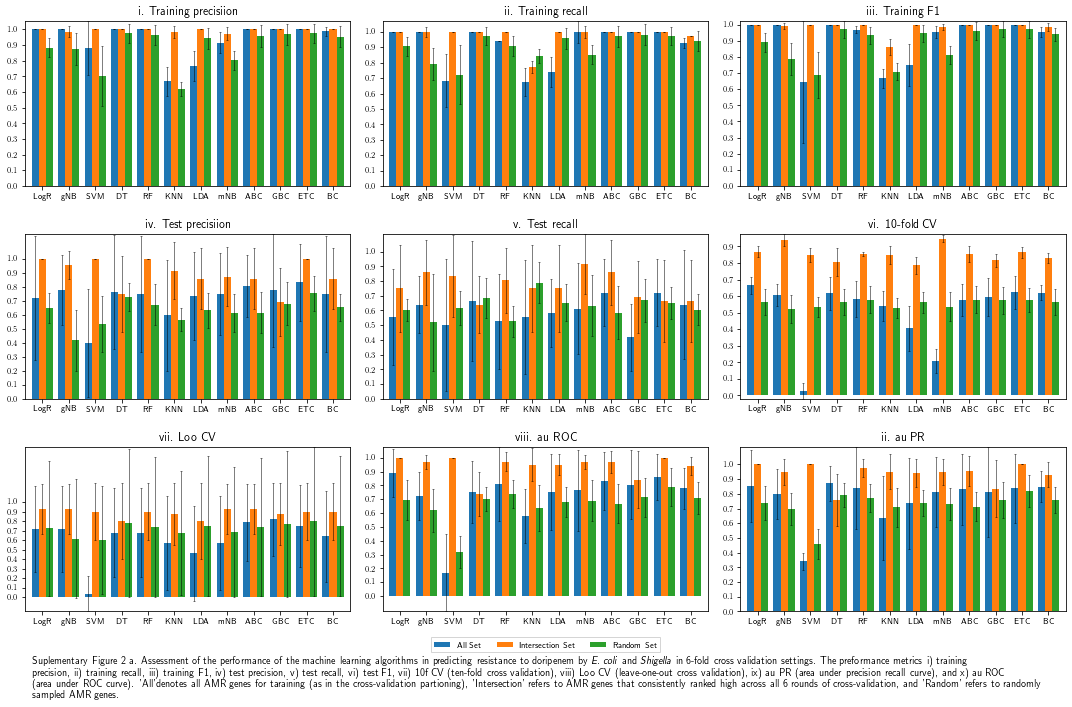

All Set Results ertapenem EcS


classifier  tr_precision_avg_as  tr_precision_stdev_as  tr_recall_avg_as  \
0        LogR                1.000                  0.000             1.000   
1         gNB                1.000                  0.000             1.000   
2         SVM                0.798                  0.026             0.813   
3          DT                1.000                  0.000             1.000   
4          RF                1.000                  0.000             0.994   
5         KNN                0.841                  0.022             0.794   
6         LDA                0.870                  0.020             0.875   
7         mNB                0.856                  0.015             0.813   
8         ABC                1.000                  0.000             1.000   
9         GBC                1.000                  0.000             1.000   
10        ETC                1.000                  0.000             1.000   
11         BC                1.000                  0.000             0.963   

    tr_recall_stdev_as  tr_f1_avg_as  tr_f1_stdev_as  te_precision_avg_as  \
0                0.000         1.000           0.000                0.911   
1                0.000         1.000           0.000                0.715   
2                0.045         0.805           0.029                0.732   
3                0.000         1.000           0.000                0.781   
4                0.015         0.997           0.008                0.836   
5                0.039         0.816           0.028                0.717   
6                0.020         0.872           0.019                0.707   
7                0.045         0.833           0.021                0.740   
8                0.000         1.000           0.000                0.815   
9                0.000         1.000           0.000                0.794   
10               0.000         1.000           0.000                0.833   
11               0.057         0.980           0.031                0.850   

    te_precision_stdev_as  te_recall_avg_as  ...  te_f1_avg_as  \
0                   0.098             0.822  ...         0.850   
1                   0.078             0.939  ...         0.809   
2                   0.079             0.828  ...         0.761   
3                   0.123             0.756  ...         0.765   
4                   0.086             0.733  ...         0.752   
5                   0.159             0.611  ...         0.641   
6                   0.088             0.672  ...         0.669   
7                   0.104             0.794  ...         0.752   
8                   0.174             0.878  ...         0.837   
9                   0.190             0.761  ...         0.766   
10                  0.091             0.822  ...         0.820   
11                  0.129             0.844  ...         0.839   

    te_f1_stdev_as  Tf_CV_Avg_as  Tf_CV_stdev_as  au_ROC_avg_as  \
0            0.113         0.806           0.029          0.970   
1            0.069         0.692           0.045          0.781   
2            0.105         0.675           0.015          0.862   
3            0.125         0.672           0.068          0.767   
4            0.157         0.719           0.025          0.884   
5            0.183         0.655           0.042          0.807   
6            0.145         0.678           0.040          0.871   
7            0.139         0.710           0.036          0.818   
8            0.140         0.773           0.061          0.854   
9            0.175         0.686           0.097          0.822   
10           0.155         0.771           0.032          0.926   
11           0.098         0.767           0.032          0.889   

    au_ROC_stdev_as  au_PR_avg_as  au_PR_stdev_as  Loo_CV_as  Loo_stdev_as  
0             0.036         0.971           0.035      0.844         0.363  
1             0.086         0.843           0.051      0.781         0.413  
2          

Intersection Set Results ertapenem EcS


classifier  tr_precision_avg_is  tr_precision_stdev_is  tr_recall_avg_is  \
0        LogR                1.000                  0.000             0.956   
1         gNB                0.900                  0.245             0.894   
2         SVM                1.000                  0.000             0.907   
3          DT                1.000                  0.000             1.000   
4          RF                1.000                  0.000             0.975   
5         KNN                0.900                  0.038             0.657   
6         LDA                1.000                  0.000             1.000   
7         mNB                0.775                  0.029             0.900   
8         ABC                1.000                  0.000             1.000   
9         GBC                1.000                  0.000             1.000   
10        ETC                1.000                  0.000             1.000   
11         BC                1.000                  0.000             0.950   

    tr_recall_stdev_is  tr_f1_avg_is  tr_f1_stdev_is  te_precision_avg_is  \
0                0.015         0.977           0.008                0.958   
1                0.060         0.872           0.148                0.885   
2                0.030         0.951           0.017                0.944   
3                0.000         1.000           0.000                0.958   
4                0.030         0.987           0.016                1.000   
5                0.039         0.758           0.018                0.814   
6                0.000         1.000           0.000                0.869   
7                0.029         0.832           0.017                0.782   
8                0.000         1.000           0.000                1.000   
9                0.000         1.000           0.000                0.930   
10               0.000         1.000           0.000                1.000   
11               0.039         0.974           0.020                0.944   

    te_precision_stdev_is  te_recall_avg_is  ...  te_f1_avg_is  \
0                   0.102             0.694  ...         0.786   
1                   0.283             0.750  ...         0.780   
2                   0.136             0.594  ...         0.719   
3                   0.102             0.722  ...         0.818   
4                   0.000             0.656  ...         0.786   
5                   0.153             0.628  ...         0.701   
6                   0.106             0.789  ...         0.820   
7                   0.149             0.856  ...         0.807   
8                   0.000             0.733  ...         0.810   
9                   0.111             0.822  ...         0.866   
10                  0.000             0.756  ...         0.851   
11                  0.136             0.728  ...         0.814   

    te_f1_stdev_is  Tf_CV_Avg_is  Tf_CV_stdev_is  au_ROC_avg_is  \
0            0.184         0.899           0.010          0.967   
1            0.229         0.899           0.080          0.907   
2            0.181         0.865           0.005          0.979   
3            0.117         0.930           0.015          0.857   
4            0.094         0.867           0.011          0.909   
5            0.198         0.844           0.017          0.916   
6            0.115         0.905           0.021          0.971   
7            0.142         0.904           0.007          0.957   
8            0.260         0.934           0.013          0.974   
9            0.137         0.945           0.012          0.966   
10           0.120         0.919           0.006          0.974   
11           0.198         0.930           0.011          0.920   

    au_ROC_stdev_is  au_PR_avg_is  au_PR_stdev_is  Loo_CV_is  Loo_stdev_is  
0             0.046         0.909           0.117      0.922         0.269  
1             0.157         0.886           0.186      0.922         0.269  
2          

Random Set Results ertapenem EcS


classifier  tr_precision_avg_rs  tr_precision_stdev_rs  tr_recall_avg_rs  \
0        LogR                0.875                  0.040             0.840   
1         gNB                0.973                  0.043             0.562   
2         SVM                0.796                  0.079             0.754   
3          DT                0.977                  0.026             0.925   
4          RF                0.969                  0.025             0.911   
5         KNN                0.731                  0.048             0.857   
6         LDA                0.955                  0.037             0.916   
7         mNB                0.861                  0.057             0.729   
8         ABC                0.955                  0.039             0.919   
9         GBC                0.963                  0.035             0.930   
10        ETC                0.977                  0.026             0.925   
11         BC                0.954                  0.026             0.903   

    tr_recall_stdev_rs  tr_f1_avg_rs  tr_f1_stdev_rs  te_precision_avg_rs  \
0                0.055         0.856           0.044                0.729   
1                0.105         0.692           0.064                0.675   
2                0.068         0.766           0.063                0.723   
3                0.049         0.949           0.036                0.740   
4                0.052         0.938           0.036                0.753   
5                0.057         0.785           0.028                0.667   
6                0.040         0.934           0.037                0.715   
7                0.104         0.782           0.059                0.713   
8                0.054         0.936           0.045                0.732   
9                0.046         0.945           0.038                0.760   
10               0.049         0.949           0.036                0.753   
11               0.036         0.927           0.028                0.750   

    te_precision_stdev_rs  te_recall_avg_rs  ...  te_f1_avg_rs  \
0                   0.071             0.689  ...         0.690   
1                   0.139             0.374  ...         0.438   
2                   0.096             0.699  ...         0.683   
3                   0.062             0.672  ...         0.684   
4                   0.087             0.632  ...         0.664   
5                   0.072             0.762  ...         0.692   
6                   0.065             0.678  ...         0.677   
7                   0.146             0.635  ...         0.645   
8                   0.047             0.682  ...         0.684   
9                   0.066             0.696  ...         0.706   
10                  0.077             0.682  ...         0.695   
11                  0.084             0.657  ...         0.676   

    te_f1_stdev_rs  Tf_CV_Avg_rs  Tf_CV_stdev_rs  Loo_CV_Avg_rs  \
0            0.077         0.678           0.069          0.766   
1            0.132         0.614           0.047          0.630   
2            0.104         0.667           0.082          0.735   
3            0.061         0.640           0.033          0.772   
4            0.086         0.662           0.030          0.767   
5            0.065         0.657           0.065          0.739   
6            0.058         0.624           0.050          0.760   
7            0.159         0.674           0.073          0.719   
8            0.069         0.667           0.049          0.780   
9            0.072         0.659           0.036          0.792   
10           0.088         0.672           0.030          0.784   
11           0.087         0.653           0.036          0.770   

    Loo_CV_stdev_rs  au_ROC_avg_rs  au_ROC_stdev_rs  au_PR_avg_rs  \
0             0.777          0.786            0.088         0.802   
1             0.680          0.731            0.075         0.766   
2             0.744          0.745 

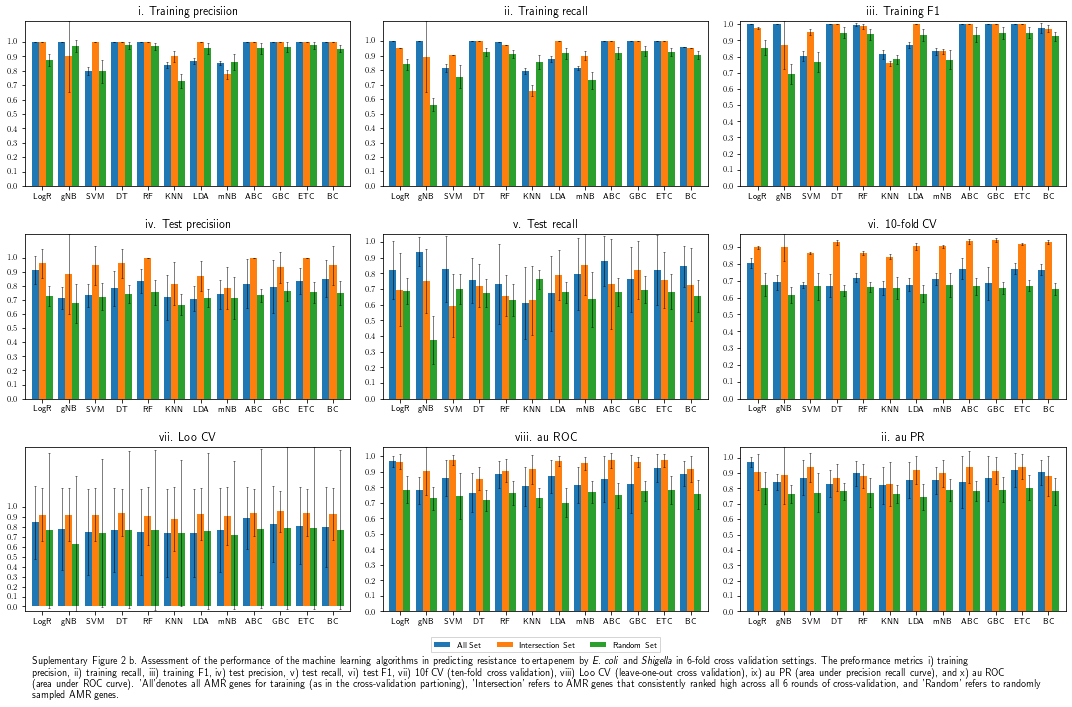

All Set Results imipenem EcS


classifier  tr_precision_avg_as  tr_precision_stdev_as  tr_recall_avg_as  \
0        LogR                1.000                  0.000             1.000   
1         gNB                1.000                  0.000             1.000   
2         SVM                0.882                  0.076             0.853   
3          DT                1.000                  0.000             1.000   
4          RF                1.000                  0.000             0.973   
5         KNN                0.817                  0.054             0.708   
6         LDA                0.784                  0.032             0.754   
7         mNB                0.942                  0.036             0.872   
8         ABC                1.000                  0.000             1.000   
9         GBC                1.000                  0.000             1.000   
10        ETC                1.000                  0.000             1.000   
11         BC                1.000                  0.000             0.991   

    tr_recall_stdev_as  tr_f1_avg_as  tr_f1_stdev_as  te_precision_avg_as  \
0                0.000         1.000           0.000                0.850   
1                0.000         1.000           0.000                0.792   
2                0.083         0.862           0.024                0.753   
3                0.000         1.000           0.000                1.000   
4                0.044         0.986           0.024                0.700   
5                0.068         0.756           0.035                0.597   
6                0.031         0.769           0.025                0.742   
7                0.075         0.904           0.048                0.767   
8                0.000         1.000           0.000                1.000   
9                0.000         1.000           0.000                1.000   
10               0.000         1.000           0.000                0.833   
11               0.023         0.995           0.012                0.967   

    te_precision_stdev_as  te_recall_avg_as  ...  te_f1_avg_as  \
0                   0.173             0.708  ...         0.713   
1                   0.188             0.778  ...         0.774   
2                   0.208             0.694  ...         0.694   
3                   0.000             0.958  ...         0.976   
4                   0.395             0.556  ...         0.574   
5                   0.335             0.570  ...         0.577   
6                   0.215             0.583  ...         0.564   
7                   0.204             0.736  ...         0.724   
8                   0.000             0.958  ...         0.976   
9                   0.000             0.958  ...         0.976   
10                  0.204             0.556  ...         0.624   
11                  0.082             0.875  ...         0.910   

    te_f1_stdev_as  Tf_CV_Avg_as  Tf_CV_stdev_as  au_ROC_avg_as  \
0            0.170         0.685           0.042          0.934   
1            0.112         0.754           0.057          0.785   
2            0.113         0.250           0.144          0.439   
3            0.058         0.961           0.027          0.979   
4            0.304         0.717           0.052          0.769   
5            0.329         0.642           0.059          0.804   
6            0.205         0.536           0.099          0.746   
7            0.096         0.500           0.060          0.783   
8            0.058         0.974           0.018          1.000   
9            0.058         0.967           0.034          1.000   
10           0.187         0.690           0.048          0.875   
11           0.071         0.806           0.048          0.979   

    au_ROC_stdev_as  au_PR_avg_as  au_PR_stdev_as  Loo_CV_as  Loo_stdev_as  
0             0.082         0.936           0.092      0.750         0.433  
1             0.116         0.841           0.109      0.773         0.419  
2          

Intersection Set Results imipenem EcS


classifier  tr_precision_avg_is  tr_precision_stdev_is  tr_recall_avg_is  \
0        LogR                1.000                  0.000             1.000   
1         gNB                0.991                  0.022             1.000   
2         SVM                1.000                  0.000             1.000   
3          DT                1.000                  0.000             1.000   
4          RF                1.000                  0.000             0.982   
5         KNN                0.978                  0.035             0.746   
6         LDA                1.000                  0.000             1.000   
7         mNB                0.949                  0.032             1.000   
8         ABC                1.000                  0.000             1.000   
9         GBC                1.000                  0.000             1.000   
10        ETC                1.000                  0.000             1.000   
11         BC                1.000                  0.000             1.000   

    tr_recall_stdev_is  tr_f1_avg_is  tr_f1_stdev_is  te_precision_avg_is  \
0                0.000         1.000           0.000                1.000   
1                0.000         0.995           0.011                0.869   
2                0.000         1.000           0.000                0.925   
3                0.000         1.000           0.000                1.000   
4                0.028         0.991           0.014                0.967   
5                0.055         0.844           0.033                0.800   
6                0.000         1.000           0.000                0.911   
7                0.000         0.973           0.017                0.911   
8                0.000         1.000           0.000                1.000   
9                0.000         1.000           0.000                1.000   
10               0.000         1.000           0.000                1.000   
11               0.000         1.000           0.000                1.000   

    te_precision_stdev_is  te_recall_avg_is  ...  te_f1_avg_is  \
0                   0.000             0.875  ...         0.921   
1                   0.149             1.000  ...         0.924   
2                   0.117             0.958  ...         0.940   
3                   0.000             0.958  ...         0.976   
4                   0.082             0.833  ...         0.858   
5                   0.400             0.597  ...         0.669   
6                   0.144             0.833  ...         0.854   
7                   0.144             1.000  ...         0.948   
8                   0.000             0.958  ...         0.976   
9                   0.000             0.958  ...         0.976   
10                  0.000             0.875  ...         0.900   
11                  0.000             1.000  ...         1.000   

    te_f1_stdev_is  Tf_CV_Avg_is  Tf_CV_stdev_is  au_ROC_avg_is  \
0            0.137         0.944           0.010          1.000   
1            0.088         0.946           0.013          0.973   
2            0.103         0.935           0.027          0.987   
3            0.058         0.998           0.005          0.979   
4            0.233         0.950           0.008          1.000   
5            0.336         0.869           0.021          0.917   
6            0.190         0.904           0.030          0.906   
7            0.085         0.980           0.015          0.997   
8            0.058         0.990           0.005          1.000   
9            0.058         0.990           0.005          1.000   
10           0.245         0.981           0.022          1.000   
11           0.000         0.992           0.006          1.000   

    au_ROC_stdev_is  au_PR_avg_is  au_PR_stdev_is  Loo_CV_is  Loo_stdev_is  
0             0.000         1.000           0.000      0.979         0.142  
1             0.034         0.935           0.075      0.969         0.173  
2          

Random Set Results imipenem EcS


classifier  tr_precision_avg_rs  tr_precision_stdev_rs  tr_recall_avg_rs  \
0        LogR                0.896                  0.055             0.867   
1         gNB                0.934                  0.080             0.666   
2         SVM                0.791                  0.091             0.738   
3          DT                0.969                  0.053             0.948   
4          RF                0.960                  0.056             0.929   
5         KNN                0.675                  0.060             0.829   
6         LDA                0.949                  0.054             0.947   
7         mNB                0.843                  0.061             0.781   
8         ABC                0.958                  0.060             0.944   
9         GBC                0.957                  0.063             0.945   
10        ETC                0.969                  0.053             0.948   
11         BC                0.949                  0.059             0.918   

    tr_recall_stdev_rs  tr_f1_avg_rs  tr_f1_stdev_rs  te_precision_avg_rs  \
0                0.046         0.878           0.038                0.645   
1                0.132         0.747           0.064                0.551   
2                0.088         0.731           0.103                0.600   
3                0.047         0.957           0.039                0.670   
4                0.045         0.942           0.038                0.722   
5                0.094         0.738           0.048                0.591   
6                0.047         0.946           0.043                0.613   
7                0.093         0.798           0.042                0.647   
8                0.048         0.949           0.047                0.603   
9                0.048         0.949           0.047                0.660   
10               0.047         0.957           0.039                0.689   
11               0.041         0.930           0.033                0.697   

    te_precision_stdev_rs  te_recall_avg_rs  ...  te_f1_avg_rs  \
0                   0.107             0.597  ...         0.596   
1                   0.187             0.429  ...         0.437   
2                   0.133             0.621  ...         0.569   
3                   0.095             0.626  ...         0.624   
4                   0.100             0.589  ...         0.619   
5                   0.094             0.725  ...         0.634   
6                   0.098             0.605  ...         0.588   
7                   0.104             0.628  ...         0.605   
8                   0.102             0.596  ...         0.581   
9                   0.102             0.643  ...         0.630   
10                  0.108             0.640  ...         0.637   
11                  0.103             0.653  ...         0.647   

    te_f1_stdev_rs  Tf_CV_Avg_rs  Tf_CV_stdev_rs  Loo_CV_Avg_rs  \
0            0.095         0.617           0.056          0.723   
1            0.184         0.591           0.063          0.629   
2            0.135         0.606           0.062          0.641   
3            0.072         0.597           0.041          0.755   
4            0.105         0.616           0.070          0.763   
5            0.087         0.580           0.046          0.684   
6            0.096         0.591           0.036          0.725   
7            0.107         0.633           0.053          0.690   
8            0.095         0.617           0.044          0.723   
9            0.078         0.621           0.037          0.759   
10           0.072         0.628           0.042          0.769   
11           0.076         0.615           0.040          0.758   

    Loo_CV_stdev_rs  au_ROC_avg_rs  au_ROC_stdev_rs  au_PR_avg_rs  \
0             0.732          0.695            0.077         0.748   
1             0.667          0.684            0.114         0.744   
2             0.641          0.527 

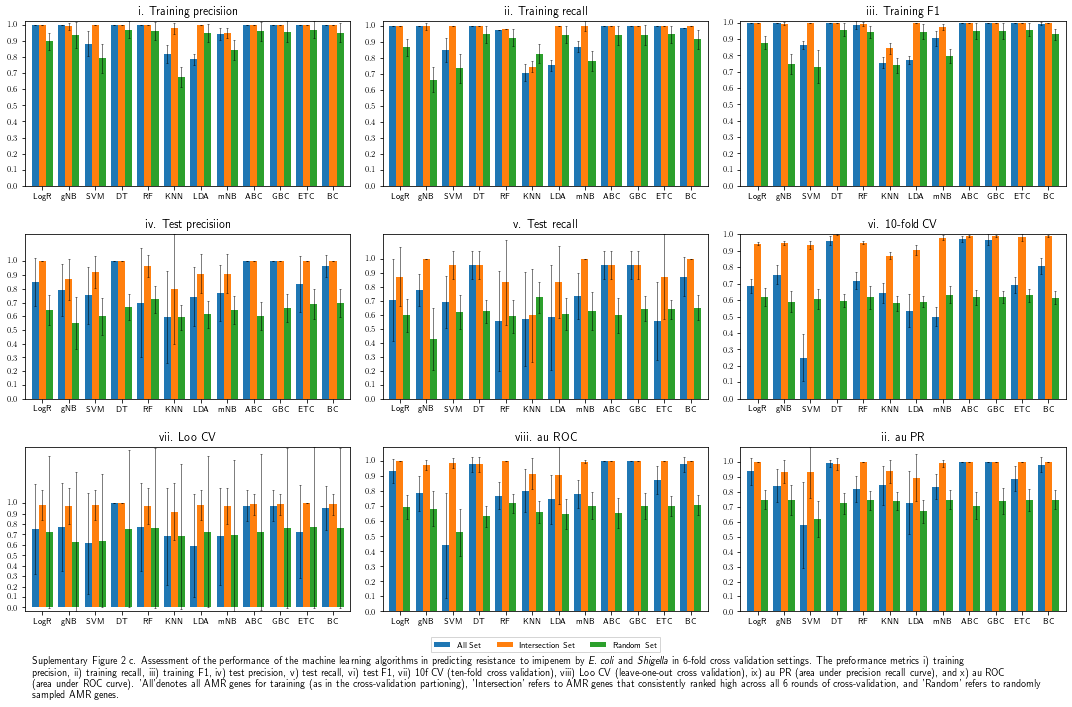

All Set Results meropenem EcS


classifier  tr_precision_avg_as  tr_precision_stdev_as  tr_recall_avg_as  \
0        LogR                1.000                  0.000             1.000   
1         gNB                1.000                  0.000             1.000   
2         SVM                0.781                  0.011             0.900   
3          DT                1.000                  0.000             1.000   
4          RF                1.000                  0.000             0.980   
5         KNN                0.806                  0.018             0.827   
6         LDA                0.803                  0.035             0.873   
7         mNB                0.795                  0.020             0.900   
8         ABC                1.000                  0.000             1.000   
9         GBC                1.000                  0.000             1.000   
10        ETC                1.000                  0.000             1.000   
11         BC                0.994                  0.016             0.987   

    tr_recall_stdev_as  tr_f1_avg_as  tr_f1_stdev_as  te_precision_avg_as  \
0                0.000         1.000           0.000                0.864   
1                0.000         1.000           0.000                0.688   
2                0.022         0.836           0.009                0.734   
3                0.000         1.000           0.000                0.817   
4                0.022         0.990           0.011                0.850   
5                0.060         0.815           0.033                0.764   
6                0.059         0.836           0.046                0.709   
7                0.022         0.844           0.015                0.781   
8                0.000         1.000           0.000                0.766   
9                0.000         1.000           0.000                0.725   
10               0.000         1.000           0.000                0.789   
11               0.021         0.990           0.011                0.870   

    te_precision_stdev_as  te_recall_avg_as  ...  te_f1_avg_as  \
0                   0.109             0.700  ...         0.750   
1                   0.189             0.800  ...         0.718   
2                   0.164             0.900  ...         0.800   
3                   0.157             0.667  ...         0.729   
4                   0.181             0.633  ...         0.688   
5                   0.139             0.700  ...         0.701   
6                   0.177             0.733  ...         0.704   
7                   0.140             0.833  ...         0.798   
8                   0.164             0.767  ...         0.751   
9                   0.177             0.667  ...         0.680   
10                  0.131             0.700  ...         0.732   
11                  0.149             0.600  ...         0.664   

    te_f1_stdev_as  Tf_CV_Avg_as  Tf_CV_stdev_as  au_ROC_avg_as  \
0            0.118         0.727           0.047          0.860   
1            0.116         0.627           0.048          0.683   
2            0.107         0.700           0.067          0.860   
3            0.105         0.697           0.051          0.750   
4            0.134         0.707           0.048          0.830   
5            0.098         0.647           0.041          0.773   
6            0.140         0.660           0.042          0.780   
7            0.073         0.683           0.034          0.810   
8            0.129         0.757           0.061          0.827   
9            0.228         0.707           0.062          0.820   
10           0.111         0.707           0.039          0.840   
11           0.196         0.743           0.043          0.867   

    au_ROC_stdev_as  au_PR_avg_as  au_PR_stdev_as  Loo_CV_as  Loo_stdev_as  
0             0.083         0.886           0.065      0.767         0.423  
1             0.147         0.794           0.098      0.700         0.458  
2          

Intersection Set Results meropenem EcS


classifier  tr_precision_avg_is  tr_precision_stdev_is  tr_recall_avg_is  \
0        LogR                1.000                  0.000             0.800   
1         gNB                0.841                  0.299             0.820   
2         SVM                1.000                  0.000             0.700   
3          DT                1.000                  0.000             0.947   
4          RF                0.986                  0.021             0.913   
5         KNN                0.942                  0.049             0.713   
6         LDA                1.000                  0.000             0.853   
7         mNB                0.814                  0.037             0.800   
8         ABC                1.000                  0.000             0.947   
9         GBC                1.000                  0.000             0.947   
10        ETC                1.000                  0.000             0.947   
11         BC                0.987                  0.021             0.940   

    tr_recall_stdev_is  tr_f1_avg_is  tr_f1_stdev_is  te_precision_avg_is  \
0                0.036         0.889           0.022                1.000   
1                0.090         0.783           0.198                0.826   
2                0.042         0.823           0.029                1.000   
3                0.033         0.972           0.017                0.755   
4                0.030         0.948           0.018                0.875   
5                0.047         0.810           0.025                0.925   
6                0.048         0.920           0.029                0.812   
7                0.057         0.805           0.015                0.803   
8                0.033         0.972           0.017                0.806   
9                0.033         0.972           0.017                0.925   
10               0.033         0.972           0.017                0.925   
11               0.033         0.962           0.016                0.925   

    te_precision_stdev_is  te_recall_avg_is  ...  te_f1_avg_is  \
0                   0.000             0.767  ...         0.856   
1                   0.319             0.700  ...         0.692   
2                   0.000             0.633  ...         0.773   
3                   0.056             0.800  ...         0.771   
4                   0.137             0.700  ...         0.773   
5                   0.117             0.633  ...         0.738   
6                   0.173             0.633  ...         0.660   
7                   0.173             0.800  ...         0.776   
8                   0.114             0.767  ...         0.775   
9                   0.117             0.733  ...         0.809   
10                  0.117             0.667  ...         0.768   
11                  0.117             0.700  ...         0.791   

    te_f1_stdev_is  Tf_CV_Avg_is  Tf_CV_stdev_is  au_ROC_avg_is  \
0            0.124         0.922           0.007          0.956   
1            0.184         0.818           0.243          0.817   
2            0.057         0.903           0.007          0.946   
3            0.062         0.884           0.016          0.866   
4            0.141         0.893           0.025          0.914   
5            0.109         0.846           0.017          0.907   
6            0.211         0.874           0.025          0.928   
7            0.081         0.872           0.011          0.931   
8            0.193         0.892           0.008          0.930   
9            0.118         0.888           0.016          0.943   
10           0.073         0.910           0.014          0.905   
11           0.087         0.899           0.018          0.943   

    au_ROC_stdev_is  au_PR_avg_is  au_PR_stdev_is  Loo_CV_is  Loo_stdev_is  
0             0.046         0.900           0.096      0.954         0.210  
1             0.168         0.777           0.115      0.901         0.299  
2          

Random Set Results meropenem EcS


classifier  tr_precision_avg_rs  tr_precision_stdev_rs  tr_recall_avg_rs  \
0        LogR                0.847                  0.062             0.857   
1         gNB                0.972                  0.069             0.573   
2         SVM                0.784                  0.066             0.845   
3          DT                0.974                  0.037             0.941   
4          RF                0.958                  0.046             0.945   
5         KNN                0.751                  0.040             0.861   
6         LDA                0.941                  0.057             0.930   
7         mNB                0.823                  0.051             0.801   
8         ABC                0.942                  0.057             0.933   
9         GBC                0.955                  0.053             0.958   
10        ETC                0.974                  0.037             0.941   
11         BC                0.955                  0.038             0.925   

    tr_recall_stdev_rs  tr_f1_avg_rs  tr_f1_stdev_rs  te_precision_avg_rs  \
0                0.031         0.850           0.032                0.741   
1                0.163         0.696           0.112                0.538   
2                0.073         0.808           0.034                0.721   
3                0.052         0.957           0.042                0.746   
4                0.035         0.951           0.039                0.768   
5                0.045         0.800           0.024                0.697   
6                0.043         0.935           0.048                0.692   
7                0.082         0.806           0.029                0.744   
8                0.054         0.937           0.054                0.696   
9                0.033         0.956           0.041                0.753   
10               0.052         0.957           0.042                0.778   
11               0.040         0.938           0.039                0.771   

    te_precision_stdev_rs  te_recall_avg_rs  ...  te_f1_avg_rs  \
0                   0.038             0.717  ...         0.703   
1                   0.210             0.320  ...         0.371   
2                   0.065             0.767  ...         0.729   
3                   0.095             0.650  ...         0.671   
4                   0.108             0.640  ...         0.667   
5                   0.058             0.780  ...         0.716   
6                   0.144             0.557  ...         0.589   
7                   0.069             0.677  ...         0.679   
8                   0.135             0.640  ...         0.646   
9                   0.086             0.643  ...         0.659   
10                  0.082             0.670  ...         0.692   
11                  0.110             0.630  ...         0.659   

    te_f1_stdev_rs  Tf_CV_Avg_rs  Tf_CV_stdev_rs  Loo_CV_Avg_rs  \
0            0.044         0.708           0.039          0.784   
1            0.205         0.592           0.071          0.590   
2            0.099         0.716           0.090          0.762   
3            0.072         0.666           0.040          0.785   
4            0.084         0.685           0.044          0.803   
5            0.075         0.703           0.041          0.765   
6            0.140         0.628           0.048          0.737   
7            0.090         0.691           0.084          0.750   
8            0.123         0.640           0.060          0.770   
9            0.083         0.677           0.043          0.799   
10           0.063         0.691           0.051          0.805   
11           0.107         0.674           0.051          0.790   

    Loo_CV_stdev_rs  au_ROC_avg_rs  au_ROC_stdev_rs  au_PR_avg_rs  \
0             0.775          0.776            0.066         0.785   
1             0.641          0.713            0.080         0.743   
2             0.770          0.715 

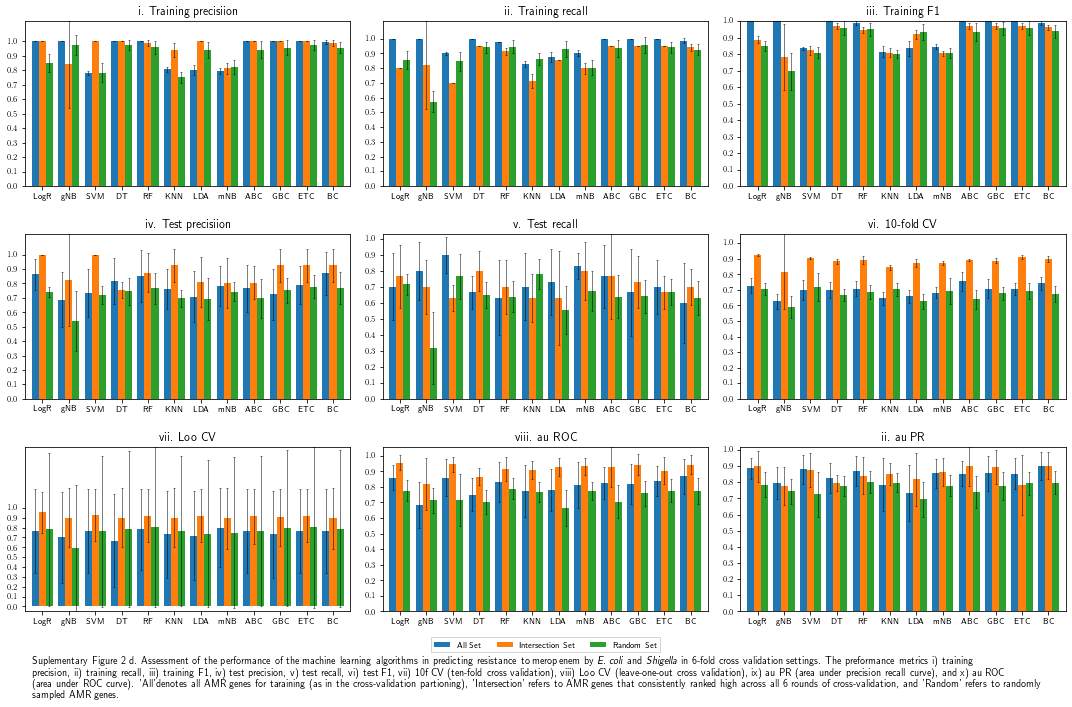

In [4]:
#All set, Intersection set and Random set performance for E. coli and Shigella

#Dictionary of antibiotics
antb_SN = {'doripenem': '2 a', 'ertapenem': '2 b', 'imipenem': '2 c', 'meropenem': '2 d'}

#import pandas
import pandas as pd

for antb, SN in antb_SN.items():
    
    #Acronym for Klebsiella pneumoniae
    bacteria = 'EcS'
    
    #Italicized full name bacteria for fig output
    it1 = r"\textit{E. coli}"
    it2 = r"\textit{Shigella}"
    italic_name = it1 + ' and ' + it2
    
    #Figure plot number
    supplementary_fig_no = SN
    
    #Import gene-ast data from github repository
    file_name = f'https://github.com/Janaksunuwar/AMRprediction_HomologyModeling_Docking/raw/main/Data/Final_Gene_AST_matrix_{bacteria}_{antb}_qc70_pi30.csv'

    #no of validation
    validation_no = 6
    
    #Result out
    file_all_out = f"{bacteria}_{antb}_Complete_Results_{validation_no}-fold_CV.csv"
    
    #read the gene-ast data
    data_ = pd.read_csv(file_name)
    
    #Put all the susceptible class in a separate dataset
    resistant = data_.loc[data_[antb] == 1]
    no_of_res = len(resistant.index)
    
    #Select equal number of resistant dataset
    susceptible = data_.loc[data_[antb] == 0].sample(n=no_of_res, random_state=42)
    
    #Concatenate both dataframes again
    data = pd.concat([resistant, susceptible])
    
    ML_Run()

All Set Results imipenem Pseudomonas


classifier  tr_precision_avg_as  tr_precision_stdev_as  tr_recall_avg_as  \
0        LogR                1.000                  0.000             1.000   
1         gNB                1.000                  0.000             1.000   
2         SVM                1.000                  0.000             0.478   
3          DT                1.000                  0.000             1.000   
4          RF                0.990                  0.016             0.956   
5         KNN                0.817                  0.062             0.561   
6         LDA                0.762                  0.018             0.673   
7         mNB                0.960                  0.019             0.600   
8         ABC                1.000                  0.000             1.000   
9         GBC                1.000                  0.000             1.000   
10        ETC                1.000                  0.000             1.000   
11         BC                1.000                  0.000             0.971   

    tr_recall_stdev_as  tr_f1_avg_as  tr_f1_stdev_as  te_precision_avg_as  \
0                0.000         1.000           0.000                0.806   
1                0.000         1.000           0.000                0.505   
2                0.057         0.645           0.053                0.833   
3                0.000         1.000           0.000                0.772   
4                0.031         0.972           0.020                0.653   
5                0.076         0.661           0.047                0.762   
6                0.041         0.714           0.030                0.662   
7                0.024         0.738           0.024                0.697   
8                0.000         1.000           0.000                0.698   
9                0.000         1.000           0.000                0.849   
10               0.000         1.000           0.000                0.763   
11               0.019         0.985           0.009                0.778   

    te_precision_stdev_as  te_recall_avg_as  ...  te_f1_avg_as  \
0                   0.164             0.607  ...         0.669   
1                   0.117             0.635  ...         0.561   
2                   0.408             0.290  ...         0.422   
3                   0.112             0.702  ...         0.731   
4                   0.146             0.460  ...         0.536   
5                   0.270             0.385  ...         0.462   
6                   0.212             0.488  ...         0.555   
7                   0.240             0.413  ...         0.507   
8                   0.205             0.484  ...         0.566   
9                   0.124             0.611  ...         0.704   
10                  0.133             0.603  ...         0.649   
11                  0.125             0.488  ...         0.590   

    te_f1_stdev_as  Tf_CV_Avg_as  Tf_CV_stdev_as  au_ROC_avg_as  \
0            0.074         0.586           0.018          0.747   
1            0.115         0.366           0.039          0.502   
2            0.242         0.077           0.052          0.609   
3            0.149         0.596           0.079          0.752   
4            0.129         0.540           0.036          0.702   
5            0.221         0.520           0.057          0.655   
6            0.189         0.424           0.045          0.621   
7            0.173         0.560           0.044          0.667   
8            0.174         0.602           0.053          0.698   
9            0.090         0.658           0.069          0.864   
10           0.123         0.599           0.045          0.777   
11           0.125         0.566           0.063          0.775   

    au_ROC_stdev_as  au_PR_avg_as  au_PR_stdev_as  Loo_CV_as  Loo_stdev_as  
0             0.116         0.788           0.074      0.659         0.474  
1             0.133         0.661           0.087      0.488         0.500  
2          

Intersection Set Results imipenem Pseudomonas


classifier  tr_precision_avg_is  tr_precision_stdev_is  tr_recall_avg_is  \
0        LogR                0.955                  0.019             0.970   
1         gNB                1.000                  0.000             0.631   
2         SVM                0.921                  0.018             0.917   
3          DT                1.000                  0.000             1.000   
4          RF                0.995                  0.007             0.976   
5         KNN                0.932                  0.017             0.774   
6         LDA                0.996                  0.007             0.998   
7         mNB                0.923                  0.016             0.732   
8         ABC                0.989                  0.013             0.989   
9         GBC                1.000                  0.000             1.000   
10        ETC                1.000                  0.000             1.000   
11         BC                0.991                  0.016             0.989   

    tr_recall_stdev_is  tr_f1_avg_is  tr_f1_stdev_is  te_precision_avg_is  \
0                0.020         0.962           0.014                0.829   
1                0.045         0.773           0.034                0.844   
2                0.011         0.918           0.010                0.840   
3                0.000         1.000           0.000                0.785   
4                0.017         0.986           0.010                0.870   
5                0.026         0.845           0.015                0.898   
6                0.005         0.996           0.004                0.773   
7                0.010         0.816           0.009                0.899   
8                0.013         0.989           0.012                0.843   
9                0.000         1.000           0.000                0.857   
10               0.000         1.000           0.000                0.868   
11               0.013         0.990           0.012                0.868   

    te_precision_stdev_is  te_recall_avg_is  ...  te_f1_avg_is  \
0                   0.054             0.824  ...         0.824   
1                   0.108             0.627  ...         0.712   
2                   0.054             0.835  ...         0.835   
3                   0.073             0.746  ...         0.758   
4                   0.047             0.857  ...         0.860   
5                   0.081             0.703  ...         0.778   
6                   0.055             0.736  ...         0.746   
7                   0.085             0.715  ...         0.791   
8                   0.071             0.835  ...         0.833   
9                   0.054             0.902  ...         0.877   
10                  0.074             0.891  ...         0.876   
11                  0.077             0.824  ...         0.843   

    te_f1_stdev_is  Tf_CV_Avg_is  Tf_CV_stdev_is  au_ROC_avg_is  \
0            0.017         0.695           0.038          0.851   
1            0.036         0.609           0.042          0.750   
2            0.032         0.645           0.031          0.859   
3            0.097         0.662           0.062          0.643   
4            0.040         0.705           0.045          0.845   
5            0.094         0.704           0.039          0.841   
6            0.096         0.583           0.064          0.668   
7            0.054         0.712           0.020          0.848   
8            0.049         0.697           0.038          0.786   
9            0.037         0.682           0.043          0.852   
10           0.032         0.700           0.034          0.852   
11           0.028         0.674           0.054          0.840   

    au_ROC_stdev_is  au_PR_avg_is  au_PR_stdev_is  Loo_CV_is  Loo_stdev_is  
0             0.054         0.921           0.043      0.773         0.419  
1             0.126         0.885           0.058      0.621         0.485  
2          

Random Set Results imipenem Pseudomonas


classifier  tr_precision_avg_rs  tr_precision_stdev_rs  tr_recall_avg_rs  \
0        LogR                0.883                  0.042             0.778   
1         gNB                0.910                  0.129             0.656   
2         SVM                0.892                  0.079             0.532   
3          DT                0.997                  0.007             0.918   
4          RF                0.952                  0.028             0.902   
5         KNN                0.743                  0.041             0.773   
6         LDA                0.934                  0.027             0.885   
7         mNB                0.888                  0.055             0.584   
8         ABC                0.924                  0.030             0.877   
9         GBC                0.964                  0.025             0.877   
10        ETC                0.997                  0.007             0.918   
11         BC                0.958                  0.018             0.916   

    tr_recall_stdev_rs  tr_f1_avg_rs  tr_f1_stdev_rs  te_precision_avg_rs  \
0                0.045         0.826           0.036                0.598   
1                0.147         0.723           0.035                0.575   
2                0.147         0.645           0.102                0.678   
3                0.047         0.955           0.027                0.583   
4                0.033         0.925           0.020                0.552   
5                0.070         0.753           0.038                0.579   
6                0.034         0.908           0.026                0.537   
7                0.101         0.696           0.064                0.641   
8                0.035         0.899           0.027                0.570   
9                0.045         0.917           0.028                0.588   
10               0.047         0.955           0.027                0.587   
11               0.038         0.936           0.021                0.593   

    te_precision_stdev_rs  te_recall_avg_rs  ...  te_f1_avg_rs  \
0                   0.077             0.534  ...         0.554   
1                   0.125             0.404  ...         0.415   
2                   0.094             0.403  ...         0.481   
3                   0.041             0.513  ...         0.532   
4                   0.030             0.498  ...         0.508   
5                   0.055             0.609  ...         0.578   
6                   0.066             0.503  ...         0.508   
7                   0.107             0.417  ...         0.488   
8                   0.064             0.529  ...         0.535   
9                   0.062             0.535  ...         0.544   
10                  0.022             0.538  ...         0.545   
11                  0.070             0.504  ...         0.521   

    te_f1_stdev_rs  Tf_CV_Avg_rs  Tf_CV_stdev_rs  Loo_CV_Avg_rs  \
0            0.066         0.566           0.045          0.679   
1            0.104         0.528           0.045          0.566   
2            0.105         0.568           0.038          0.574   
3            0.032         0.532           0.045          0.691   
4            0.053         0.535           0.043          0.677   
5            0.077         0.539           0.036          0.634   
6            0.080         0.532           0.046          0.667   
7            0.066         0.566           0.038          0.611   
8            0.067         0.542           0.048          0.677   
9            0.079         0.545           0.049          0.686   
10           0.052         0.539           0.042          0.698   
11           0.067         0.531           0.028          0.682   

    Loo_CV_stdev_rs  au_ROC_avg_rs  au_ROC_stdev_rs  au_PR_avg_rs  \
0             0.675          0.638            0.055         0.677   
1             0.667          0.570            0.062         0.650   
2             0.582          0.489 

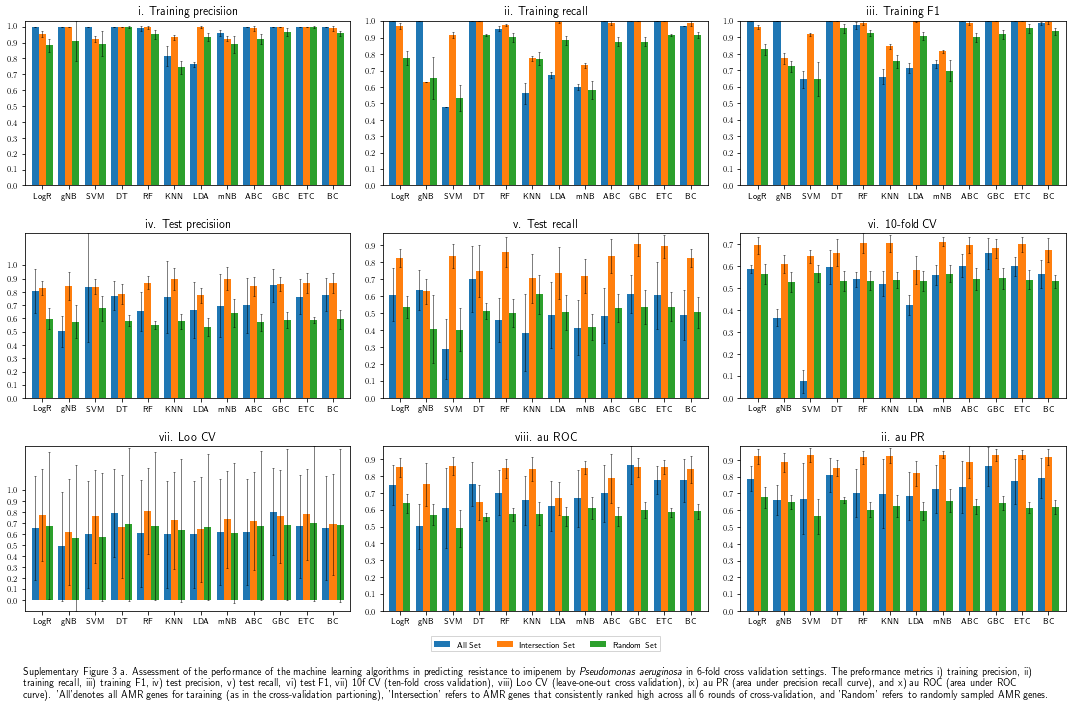

All Set Results meropenem Pseudomonas


classifier  tr_precision_avg_as  tr_precision_stdev_as  tr_recall_avg_as  \
0        LogR                1.000                  0.000             1.000   
1         gNB                1.000                  0.000             1.000   
2         SVM                0.968                  0.028             0.608   
3          DT                1.000                  0.000             1.000   
4          RF                1.000                  0.000             0.942   
5         KNN                0.879                  0.049             0.638   
6         LDA                0.827                  0.020             0.771   
7         mNB                0.964                  0.031             0.646   
8         ABC                1.000                  0.000             1.000   
9         GBC                1.000                  0.000             1.000   
10        ETC                1.000                  0.000             1.000   
11         BC                0.995                  0.011             0.946   

    tr_recall_stdev_as  tr_f1_avg_as  tr_f1_stdev_as  te_precision_avg_as  \
0                0.000         1.000           0.000                0.726   
1                0.000         1.000           0.000                0.592   
2                0.034         0.746           0.024                0.861   
3                0.000         1.000           0.000                0.621   
4                0.047         0.969           0.025                0.845   
5                0.041         0.737           0.018                0.744   
6                0.025         0.797           0.011                0.833   
7                0.029         0.773           0.018                0.847   
8                0.000         1.000           0.000                0.700   
9                0.000         1.000           0.000                0.646   
10               0.000         1.000           0.000                0.767   
11               0.037         0.970           0.023                0.642   

    te_precision_stdev_as  te_recall_avg_as  ...  te_f1_avg_as  \
0                   0.051             0.583  ...         0.625   
1                   0.070             0.812  ...         0.678   
2                   0.164             0.438  ...         0.529   
3                   0.198             0.583  ...         0.562   
4                   0.198             0.542  ...         0.628   
5                   0.159             0.500  ...         0.579   
6                   0.143             0.542  ...         0.621   
7                   0.168             0.438  ...         0.504   
8                   0.120             0.646  ...         0.668   
9                   0.072             0.604  ...         0.620   
10                  0.158             0.583  ...         0.631   
11                  0.162             0.583  ...         0.606   

    te_f1_stdev_as  Tf_CV_Avg_as  Tf_CV_stdev_as  au_ROC_avg_as  \
0            0.183         0.558           0.031          0.708   
1            0.103         0.446           0.015          0.625   
2            0.229         0.171           0.074          0.753   
3            0.198         0.562           0.048          0.594   
4            0.158         0.546           0.067          0.725   
5            0.233         0.567           0.045          0.715   
6            0.202         0.529           0.060          0.721   
7            0.265         0.615           0.031          0.706   
8            0.136         0.519           0.065          0.701   
9            0.087         0.525           0.061          0.724   
10           0.115         0.536           0.031          0.760   
11           0.177         0.588           0.031          0.737   

    au_ROC_stdev_as  au_PR_avg_as  au_PR_stdev_as  Loo_CV_as  Loo_stdev_as  
0             0.139         0.749           0.124      0.656         0.475  
1             0.097         0.750           0.069      0.615         0.487  
2          

Intersection Set Results meropenem Pseudomonas


classifier  tr_precision_avg_is  tr_precision_stdev_is  tr_recall_avg_is  \
0        LogR                0.981                  0.012             0.967   
1         gNB                1.000                  0.000             0.719   
2         SVM                0.964                  0.015             0.957   
3          DT                1.000                  0.000             1.000   
4          RF                1.000                  0.000             0.988   
5         KNN                0.942                  0.020             0.728   
6         LDA                0.998                  0.006             1.000   
7         mNB                0.943                  0.026             0.824   
8         ABC                0.995                  0.007             0.995   
9         GBC                1.000                  0.000             1.000   
10        ETC                1.000                  0.000             1.000   
11         BC                0.998                  0.006             0.988   

    tr_recall_stdev_is  tr_f1_avg_is  tr_f1_stdev_is  te_precision_avg_is  \
0                0.020         0.974           0.013                0.814   
1                0.053         0.836           0.035                0.943   
2                0.018         0.960           0.015                0.864   
3                0.000         1.000           0.000                0.807   
4                0.014         0.994           0.007                0.869   
5                0.034         0.821           0.024                0.900   
6                0.000         0.999           0.003                0.772   
7                0.023         0.880           0.021                0.877   
8                0.007         0.995           0.007                0.816   
9                0.000         1.000           0.000                0.800   
10               0.000         1.000           0.000                0.820   
11               0.014         0.993           0.009                0.829   

    te_precision_stdev_is  te_recall_avg_is  ...  te_f1_avg_is  \
0                   0.071             0.845  ...         0.826   
1                   0.090             0.690  ...         0.784   
2                   0.071             0.893  ...         0.876   
3                   0.127             0.786  ...         0.795   
4                   0.058             0.786  ...         0.823   
5                   0.084             0.631  ...         0.738   
6                   0.049             0.643  ...         0.696   
7                   0.043             0.774  ...         0.818   
8                   0.040             0.786  ...         0.795   
9                   0.074             0.822  ...         0.809   
10                  0.110             0.810  ...         0.814   
11                  0.089             0.726  ...         0.772   

    te_f1_stdev_is  Tf_CV_Avg_is  Tf_CV_stdev_is  au_ROC_avg_is  \
0            0.106         0.726           0.042          0.868   
1            0.136         0.733           0.037          0.897   
2            0.078         0.771           0.026          0.892   
3            0.124         0.662           0.068          0.726   
4            0.077         0.698           0.036          0.856   
5            0.090         0.680           0.023          0.819   
6            0.086         0.579           0.060          0.651   
7            0.088         0.762           0.030          0.872   
8            0.084         0.702           0.049          0.807   
9            0.094         0.699           0.065          0.856   
10           0.106         0.717           0.053          0.871   
11           0.065         0.703           0.043          0.835   

    au_ROC_stdev_is  au_PR_avg_is  au_PR_stdev_is  Loo_CV_is  Loo_stdev_is  
0             0.092         0.920           0.056      0.795         0.403  
1             0.086         0.945           0.051      0.773         0.419  
2          

Random Set Results meropenem Pseudomonas


classifier  tr_precision_avg_rs  tr_precision_stdev_rs  tr_recall_avg_rs  \
0        LogR                0.881                  0.040             0.786   
1         gNB                0.978                  0.045             0.540   
2         SVM                0.867                  0.055             0.603   
3          DT                0.998                  0.005             0.957   
4          RF                0.983                  0.013             0.925   
5         KNN                0.774                  0.040             0.765   
6         LDA                0.943                  0.028             0.888   
7         mNB                0.881                  0.032             0.567   
8         ABC                0.930                  0.021             0.891   
9         GBC                0.980                  0.008             0.879   
10        ETC                0.998                  0.005             0.957   
11         BC                0.978                  0.011             0.938   

    tr_recall_stdev_rs  tr_f1_avg_rs  tr_f1_stdev_rs  te_precision_avg_rs  \
0                0.046         0.830           0.036                0.666   
1                0.071         0.685           0.045                0.707   
2                0.125         0.698           0.088                0.730   
3                0.029         0.977           0.016                0.640   
4                0.028         0.952           0.017                0.639   
5                0.069         0.766           0.033                0.590   
6                0.024         0.914           0.024                0.589   
7                0.108         0.683           0.083                0.738   
8                0.030         0.910           0.024                0.595   
9                0.035         0.926           0.020                0.630   
10               0.029         0.977           0.016                0.646   
11               0.021         0.957           0.012                0.627   

    te_precision_stdev_rs  te_recall_avg_rs  ...  te_f1_avg_rs  \
0                   0.065             0.596  ...         0.614   
1                   0.129             0.331  ...         0.423   
2                   0.073             0.496  ...         0.562   
3                   0.089             0.604  ...         0.596   
4                   0.049             0.544  ...         0.572   
5                   0.039             0.612  ...         0.587   
6                   0.080             0.542  ...         0.554   
7                   0.058             0.440  ...         0.517   
8                   0.060             0.569  ...         0.571   
9                   0.066             0.548  ...         0.570   
10                  0.073             0.575  ...         0.591   
11                  0.051             0.558  ...         0.571   

    te_f1_stdev_rs  Tf_CV_Avg_rs  Tf_CV_stdev_rs  Loo_CV_Avg_rs  \
0            0.061         0.613           0.043          0.708   
1            0.075         0.574           0.052          0.607   
2            0.085         0.619           0.035          0.673   
3            0.043         0.591           0.038          0.734   
4            0.039         0.587           0.037          0.730   
5            0.041         0.570           0.044          0.655   
6            0.066         0.557           0.033          0.695   
7            0.067         0.620           0.032          0.650   
8            0.068         0.586           0.034          0.710   
9            0.066         0.599           0.041          0.720   
10           0.059         0.612           0.039          0.740   
11           0.054         0.576           0.041          0.727   

    Loo_CV_stdev_rs  au_ROC_avg_rs  au_ROC_stdev_rs  au_PR_avg_rs  \
0             0.703          0.662            0.075         0.715   
1             0.626          0.640            0.080         0.688   
2             0.629          0.629 

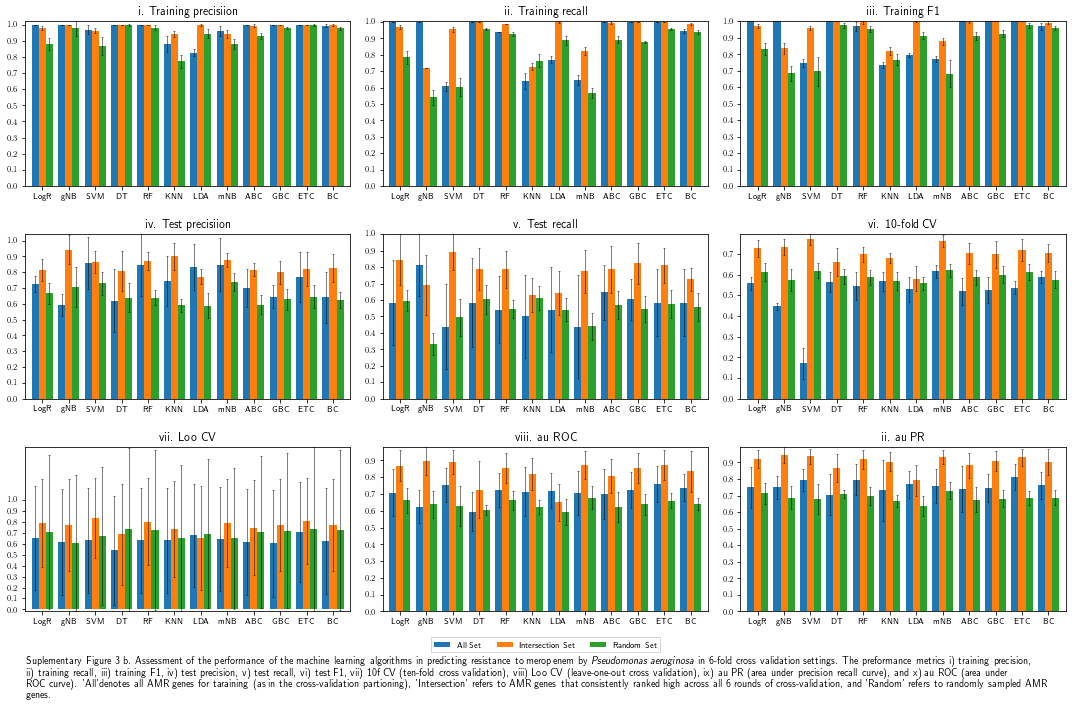

In [5]:
#All set, Intersection set and Random set performance for Pseudomonas aeruginosa

#Dictionary of antibiotics
antb_SN = {'imipenem': '3 a', 'meropenem': '3 b'}

#import pandas
import pandas as pd

for antb, SN in antb_SN.items():
    
    #Acronym for Pseudomonas aeruginosa
    bacteria = 'Pseudomonas'
    
    #Italicized full name bacteria for fig output
    italic_name = r"\textit{Pseudomonas aeruginosa}"
    
    #Figure plot number
    supplementary_fig_no = SN
    
    #Import gene-ast data from github repository
    file_name = f'https://github.com/Janaksunuwar/AMRprediction_HomologyModeling_Docking/raw/main/Data/Final_Gene_AST_matrix_{bacteria}_{antb}_qc70_pi30.csv'

    #no of validation
    validation_no = 6
    
    #Result out
    file_all_out = f"{bacteria}_{antb}_Complete_Results_{validation_no}-fold_CV.csv"
    
    #read the gene-ast data
    data_ = pd.read_csv(file_name)
    
    #Put all the susceptible class in a separate dataset
    susceptible = data_.loc[data_[antb] == 0]
    no_of= len(susceptible.index)
    
    #Select equal number of resistant dataset
    resistant = data_.loc[data_[antb] == 1].sample(n=no_of, random_state=42)
    
    #Concatenate both dataframes again
    data = pd.concat([resistant, susceptible])
    
    ML_Run()